In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import math

In [103]:
def dict_save(dictionary,path):
    with open(path,'wb') as handle:
        pickle.dump(dictionary, handle)
    return 0

def dict_load(path):
    with open(path,'rb') as handle:
        result = pickle.load(handle)
    return result

In [253]:
def loss_read(file_path):
    loss_dict = {}
    
    with open(file_path, 'r') as rf:
        lines = rf.readlines()
        
        for line in lines:
            if line[39:46] == '[train]':
                flag = True
                sk = 'train'
            elif line[39:44] == '[val]':
                flag = True
                sk = 'val'
            else:
                flag = False
                
            if flag:
                if not sk in loss_dict.keys():
                    loss_dict[sk] = {'iter':[], 'all':[]}
                
                line = line.strip('\n').split(' | ')
                idx = int(line[0].split(' ')[-1])
                loss_dict[sk]['iter'].append(idx)
                
                #loss = float(line[1].split(' ')[-1])
                #loss_rot = float(line[2].split(' ')[-1])
                #loss_pos = float(line[3].split(' ')[-1])
                #loss_seq = float(line[4].split(' ')[-1])
                
                #loss_dict[sk]['all'].append(loss)
                #loss_dict[sk]['rot'].append(loss_rot)
                #loss_dict[sk]['pos'].append(loss_pos)
                #loss_dict[sk]['seq'].append(loss_seq)
                
                for loss_term in line[1:]:
                    if 'loss' in loss_term:
                        loss = float(loss_term.split(' ')[-1])
                        
                        if '(' in loss_term:
                            loss_name = loss_term.split('(')[1].split(')')[0]
                        else:
                            loss_name = 'all'
                            
                        if loss_name not in loss_dict[sk]:
                            loss_dict[sk][loss_name] = [loss]
                        else:
                            loss_dict[sk][loss_name].append(loss)
                
    return loss_dict

In [254]:
def loss_ave(idx_list, loss_list, inter = 1000):
    '''For each <inter> iterations, take the average of the losses.'''
    loss_temp = []
    loss_out = []
    idx_out = []
    for i,l in enumerate(loss_list):
        loss_temp.append(l)
        if len(loss_temp) == inter:
            idx_out.append(idx_list[i])
            loss_out.append(np.mean(loss_temp))
            loss_temp = []
    if len(loss_temp) > 0:
        idx_out.append(idx_list[-1])
        loss_out.append(np.mean(loss_temp))
    return idx_out, loss_out

In [255]:
def loss_plot(loss_dict, inter = 1000, loss_type_list = ['rot', 'pos', 'seq'],
              color_list = ['red', 'blue', 'orange', 'green', 'purple']):
    plt.figure(figsize = (15, 4))
    ### overall
    plt.subplot(1,3,1)
    for i,sk in enumerate(['train', 'val']):
        if sk not in loss_dict:
            continue
        
        if sk == 'train':
            idx_list, loss_list = loss_ave(loss_dict[sk]['iter'], loss_dict[sk]['all'], inter = inter)
        else:
            idx_list, loss_list = loss_dict[sk]['iter'], loss_dict[sk]['all']
        plt.plot(idx_list, loss_list, label = sk, color = color_list[i])
    plt.xlabel('Iterations', fontsize = 12)
    plt.ylabel('Loss', fontsize = 12)
    plt.legend(fontsize = 10)
    
    ### separate loss
    for i,sk in enumerate(['train', 'val']):
        if sk not in loss_dict:
            continue
        
        plt.subplot(1,3,i+2)
        for j,version in enumerate(loss_type_list):
            if (version not in loss_dict[sk]) or (len(loss_dict[sk][version]) == 0):
                continue
            
            if sk == 'train':
                idx_list, loss_list = loss_ave(loss_dict[sk]['iter'], loss_dict[sk][version], inter = inter)
            else:
                idx_list, loss_list = loss_dict[sk]['iter'], loss_dict[sk][version]
            plt.plot(idx_list, loss_list, label = version, color = color_list[2 + j])
            
        plt.xlabel('Iterations', fontsize = 12)
        plt.ylabel('Loss', fontsize = 12)
        plt.title(sk, fontsize = 15)
        plt.legend(fontsize = 10)
    plt.show()

In [256]:
def convergent_check(loss_list, iter_list = None):
    if len(loss_list) == 0:
        print('Unconverged')
        return None
    
    num = 0
    idx = np.argmin(loss_list)
    loss_min = loss_list[idx]
    if idx == len(loss_list) - 1:
        print('Unconverged')
        return None
    else:
        if iter_list is not None:
            idx = iter_list[idx]
        print('Coverged at Iter %d (%f).'%(idx, loss_min))
        return idx

In [257]:
def loss_wrapper(loss_list, sk, idx, interval):
    """For training set take the mean; otherwise take the point."""
    if sk ==' train':
        return  np.mean(loss_list[idx - interval : idx])
    else:
        return  loss_list[idx]

In [352]:
def model_stat(model_list, version_list, title, log_path, 
               loss_type_list = ['rot', 'pos', 'seq'], iter_sele_dict = None, interval = 1000,
               color_list = ['red', 'blue', 'orange', 'green', 'purple']):
    
    if iter_sele_dict is None:
        iter_sele_dict = {}
    
    for i, ver in enumerate(version_list):
        print('%s = %s'%(title, ver))
        
        model = model_list[i]
        path = os.path.join(log_path, model, 'log.txt')
        
        ###### read the losses ######
        loss_dict = loss_read(path)

        ###### stopping point ######
        if 'val' not in loss_dict: # no validation
            iter_sele = None
        else:
            iter_sele = convergent_check(loss_dict['val']['all'], iter_list = loss_dict['val']['iter'])
        
        if iter_sele is None: # unconverge
            loss_plot(loss_dict, inter = interval)
            continue
            
        ###### save the losses of this model ###### 
        iter_sele_dict[model_list[i]] = {'iter': iter_sele}
        
        for sk in ['train', 'val']:
            ### different datasets
            
            if sk not in loss_dict:
                continue
            
            iter_sele_dict[model_list[i]][sk] = {}
            idx = loss_dict[sk]['iter'].index(iter_sele)
               
            ### different losses
            for loss_type in ['all'] + loss_type_list:
                if loss_type not in loss_dict[sk]:
                    continue
                
                iter_sele_dict[model_list[i]][sk]['loss_%s' % loss_type] = loss_wrapper(
                    loss_dict[sk][loss_type], sk, idx, interval
                )
            
            ### print out the losses
            text = '%s: loss=%.4f;' % (sk, 
                                       iter_sele_dict[model_list[i]][sk]['loss_all'])
            text_overleaf = 'for overleaf: %.3f' % iter_sele_dict[model_list[i]][sk]['loss_all']
                
            for loss_type in loss_type_list:
                if ('loss_%s' % loss_type) not in iter_sele_dict[model_list[i]][sk]:
                    continue
                
                text += ' %s=%.4f;' % (loss_type,
                                       iter_sele_dict[model_list[i]][sk]['loss_%s' % loss_type])
                text_overleaf += ' & %.3f' % iter_sele_dict[model_list[i]][sk]['loss_%s' % loss_type]
                
            text = text.strip(';')
            print(text)
            print(text_overleaf)

        ###### plot the loss ######
        loss_plot(loss_dict, loss_type_list = loss_type_list, inter = interval, color_list = color_list)

    return iter_sele_dict

In [317]:
# stopping point of the models
iter_sele_dict = {}
interval = 1000 # validation step

# Joint-Diffusion

## Hyper-parameter Tuning

In [318]:
LOG_PATH = '../../Logs/logs_originDiff/'

### Different Versions

In [353]:
title = 'Version'
version_list = ['"diffab"', '"non-share"', '"encoder-share"', 
                '"single-gpu"', '"RememberPadding"', '"max-sample"']

model_list = [
    'codesign_diffab_diffab_gen_share-false_step100_lr1.e-4_wd0.0_2023_05_01__17_18_33',
    'codesign_diffab_complete_gen_share-false_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_singleGPU_2023_05_01__17_13_12',
    'codesign_RememberPadding_2024_01_29__20_57_00',
    'codesign_SingleChain_2023_10_06__00_47_00_diffab_max'
]

Version = "diffab"
Coverged at Iter 894000 (1.625200).
train: loss=1.8988; rot=1.3905; pos=0.2849; seq=0.2233
for overleaf: 1.899 & 1.391 & 0.285 & 0.223
val: loss=1.6252; rot=1.1369; pos=0.2599; seq=0.2284
for overleaf: 1.625 & 1.137 & 0.260 & 0.228


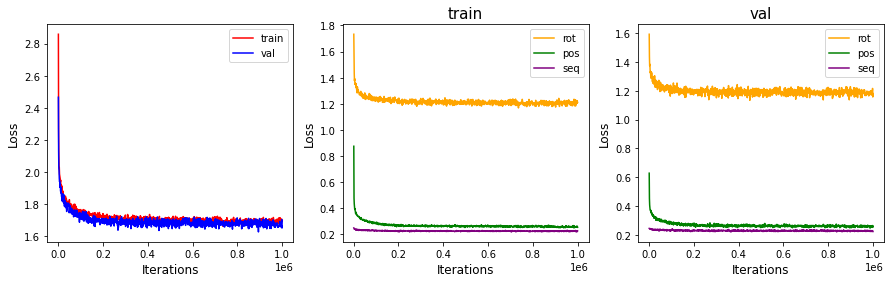

Version = "non-share"
Coverged at Iter 838000 (1.639900).
train: loss=2.2469; rot=1.9447; pos=0.1683; seq=0.1339
for overleaf: 2.247 & 1.945 & 0.168 & 0.134
val: loss=1.6399; rot=1.1461; pos=0.2669; seq=0.2269
for overleaf: 1.640 & 1.146 & 0.267 & 0.227


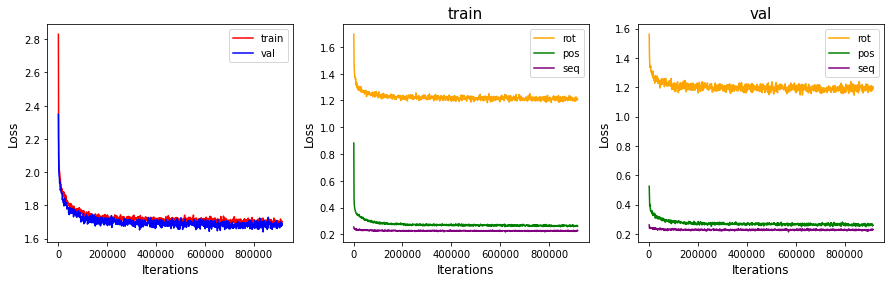

Version = "encoder-share"
Coverged at Iter 458000 (1.608100).
train: loss=1.5579; rot=1.1359; pos=0.2059; seq=0.2160
for overleaf: 1.558 & 1.136 & 0.206 & 0.216
val: loss=1.6081; rot=1.1153; pos=0.2573; seq=0.2355
for overleaf: 1.608 & 1.115 & 0.257 & 0.235


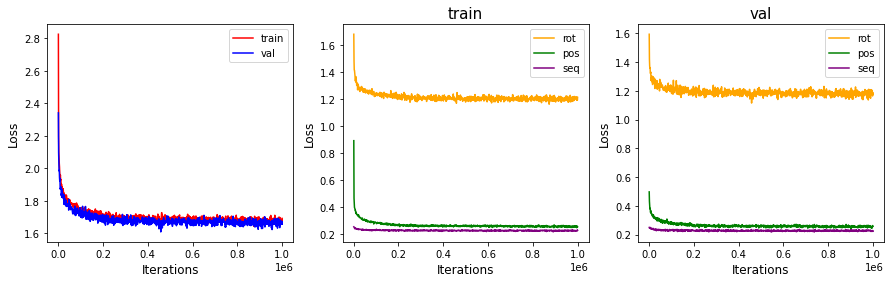

Version = "single-gpu"
Coverged at Iter 818000 (1.648700).
train: loss=1.7453; rot=0.6238; pos=0.8826; seq=0.2390
for overleaf: 1.745 & 0.624 & 0.883 & 0.239
val: loss=1.6487; rot=1.1473; pos=0.2735; seq=0.2279
for overleaf: 1.649 & 1.147 & 0.274 & 0.228


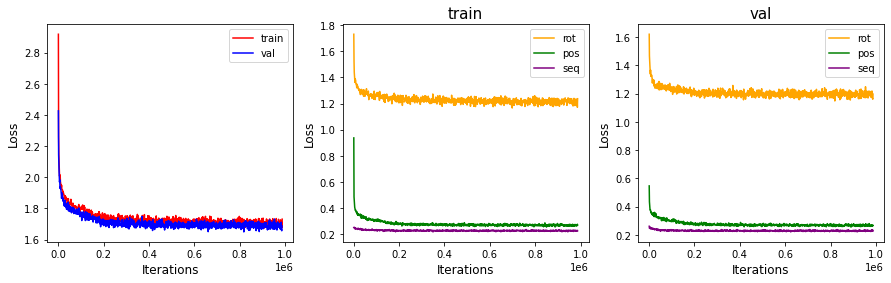

Version = "RememberPadding"
Coverged at Iter 783000 (1.621600).
train: loss=1.8738; rot=1.5104; pos=0.1711; seq=0.1923
for overleaf: 1.874 & 1.510 & 0.171 & 0.192
val: loss=1.6216; rot=1.1241; pos=0.2646; seq=0.2329
for overleaf: 1.622 & 1.124 & 0.265 & 0.233


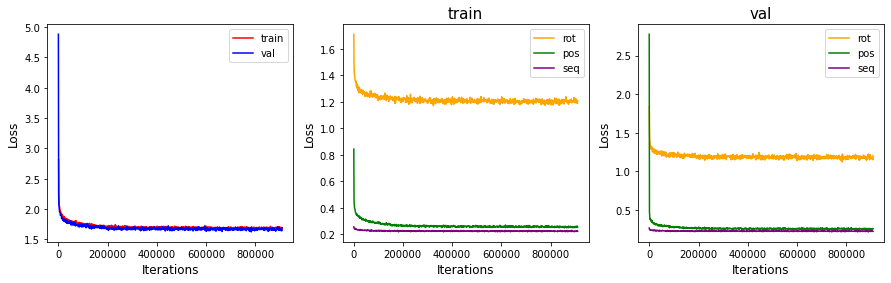

Version = "max-sample"
Coverged at Iter 474000 (1.953400).
train: loss=2.3358; rot=2.2170; pos=0.1188; seq=0.0000
for overleaf: 2.336 & 2.217 & 0.119 & 0.000
val: loss=1.9534; rot=1.2028; pos=0.2837; seq=0.4668
for overleaf: 1.953 & 1.203 & 0.284 & 0.467


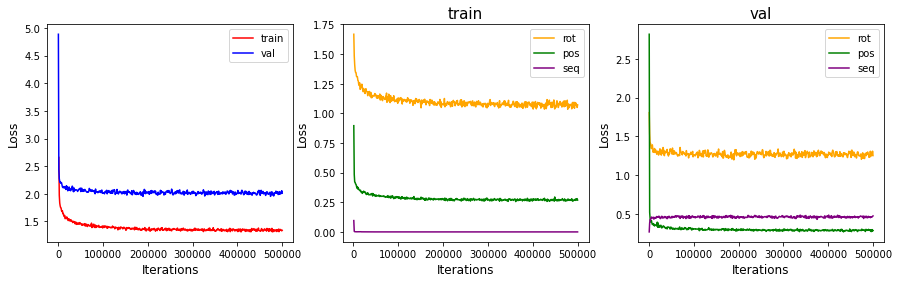

In [354]:
iter_sele_dict = model_stat(
    model_list = model_list, 
    version_list = version_list, 
    title = title, 
    log_path = LOG_PATH, 
    loss_type_list = ['rot', 'pos', 'seq'], 
    iter_sele_dict = iter_sele_dict, 
    interval = interval
)

**Conclusion** \
The different versions would have similar validation losses: \
1) The complete version can have similar performance as the original diffab and save some parameters (3,608, 226 vs 3,660,834) \
2) Sharing encoder would have a little better performance but would cost more weights? (3,608,226 vs 3,465,122 ?) \
3) similar performance for single-GPU and multiple GPU; the latter is a little better but may result from the larger batch size.

### Initial Learning Rate

In [355]:
title = 'lr'
version_list = ['1e-5', '5e-5', '1e-4', '5e-4', '1e-3']

model_list = [
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-5_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr5.e-5_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr5.e-4_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-3_wd0.0_2023_05_01__17_05_48'
]

lr = 1e-5
Coverged at Iter 920000 (1.687800).
train: loss=0.8786; rot=0.2781; pos=0.2864; seq=0.3142
for overleaf: 0.879 & 0.278 & 0.286 & 0.314
val: loss=1.6878; rot=1.1718; pos=0.2820; seq=0.2341
for overleaf: 1.688 & 1.172 & 0.282 & 0.234


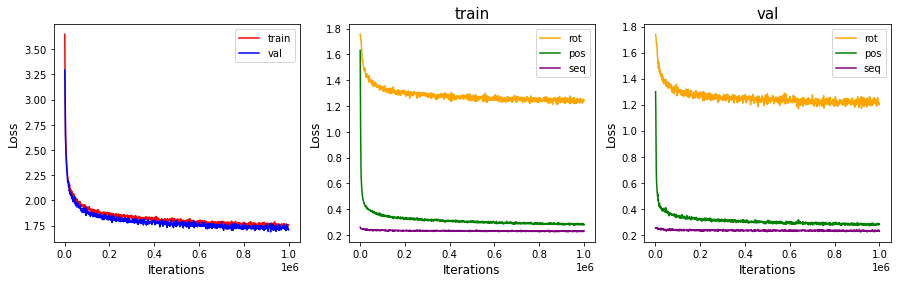

lr = 5e-5
Coverged at Iter 920000 (1.633600).
train: loss=0.8152; rot=0.2544; pos=0.2573; seq=0.3035
for overleaf: 0.815 & 0.254 & 0.257 & 0.303
val: loss=1.6336; rot=1.1404; pos=0.2619; seq=0.2313
for overleaf: 1.634 & 1.140 & 0.262 & 0.231


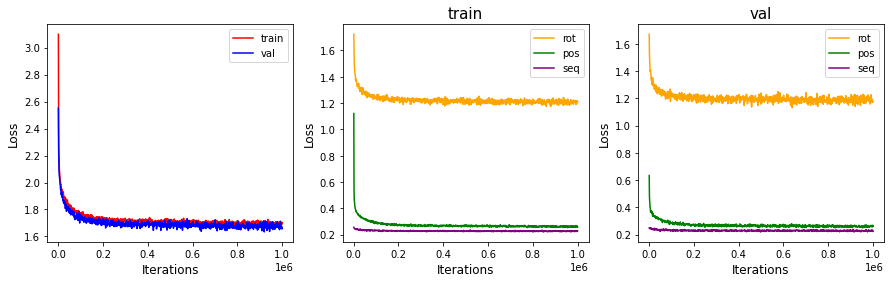

lr = 1e-4
Coverged at Iter 458000 (1.608100).
train: loss=1.5579; rot=1.1359; pos=0.2059; seq=0.2160
for overleaf: 1.558 & 1.136 & 0.206 & 0.216
val: loss=1.6081; rot=1.1153; pos=0.2573; seq=0.2355
for overleaf: 1.608 & 1.115 & 0.257 & 0.235


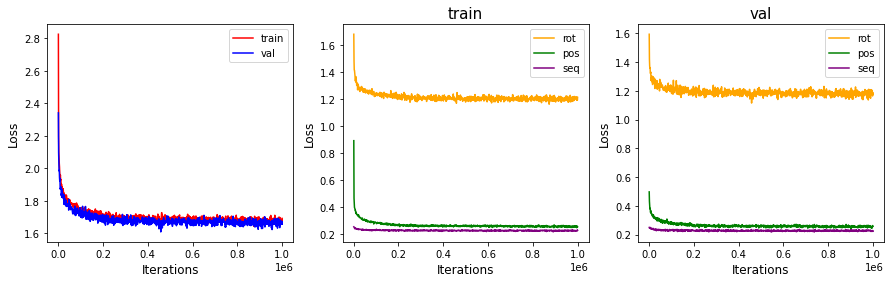

lr = 5e-4
Coverged at Iter 999000 (1.642000).
train: loss=1.9878; rot=1.7163; pos=0.1714; seq=0.1001
for overleaf: 1.988 & 1.716 & 0.171 & 0.100
val: loss=1.6420; rot=1.1467; pos=0.2658; seq=0.2295
for overleaf: 1.642 & 1.147 & 0.266 & 0.230


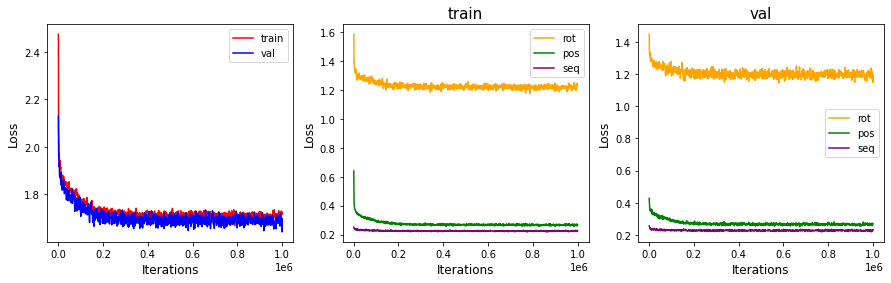

lr = 1e-3
Coverged at Iter 815000 (1.653900).
train: loss=1.3330; rot=0.6685; pos=0.5064; seq=0.1582
for overleaf: 1.333 & 0.668 & 0.506 & 0.158
val: loss=1.6539; rot=1.1507; pos=0.2712; seq=0.2320
for overleaf: 1.654 & 1.151 & 0.271 & 0.232


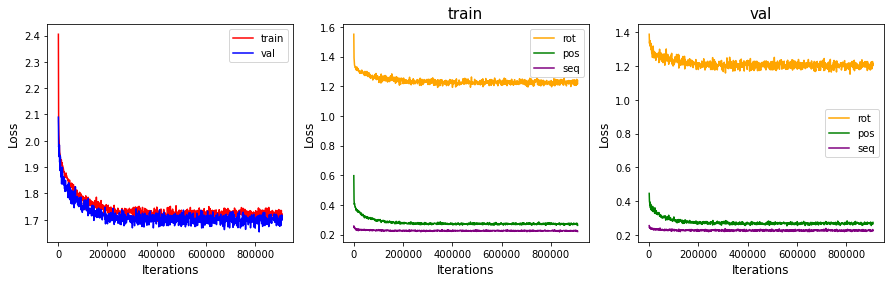

In [356]:
iter_sele_dict = model_stat(
    model_list = model_list, 
    version_list = version_list, 
    title = title, 
    log_path = LOG_PATH, 
    loss_type_list = ['rot', 'pos', 'seq'], 
    iter_sele_dict = iter_sele_dict, 
    interval = interval
)

**Conclusion** \
lr=1e-4 selected with the lowest vali loss of 1.6081 at Iter458000. (wd = 0, step = 100)

### Decaying Weight

In [357]:
title = 'wd'
version_list = ['0.0', '0.01', '0.05']

model_list = [
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.01_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.05_2023_05_01__17_05_48'
]

wd = 0.0
Coverged at Iter 458000 (1.608100).
train: loss=1.5579; rot=1.1359; pos=0.2059; seq=0.2160
for overleaf: 1.558 & 1.136 & 0.206 & 0.216
val: loss=1.6081; rot=1.1153; pos=0.2573; seq=0.2355
for overleaf: 1.608 & 1.115 & 0.257 & 0.235


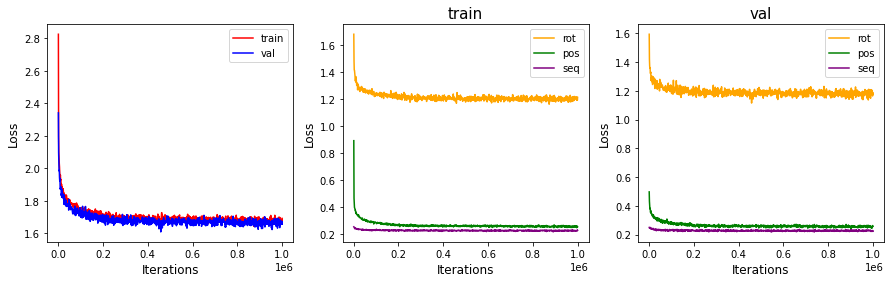

wd = 0.01
Coverged at Iter 400000 (2.179100).
train: loss=2.1176; rot=1.3291; pos=0.4755; seq=0.3130
for overleaf: 2.118 & 1.329 & 0.475 & 0.313
val: loss=2.1791; rot=1.4394; pos=0.4780; seq=0.2617
for overleaf: 2.179 & 1.439 & 0.478 & 0.262


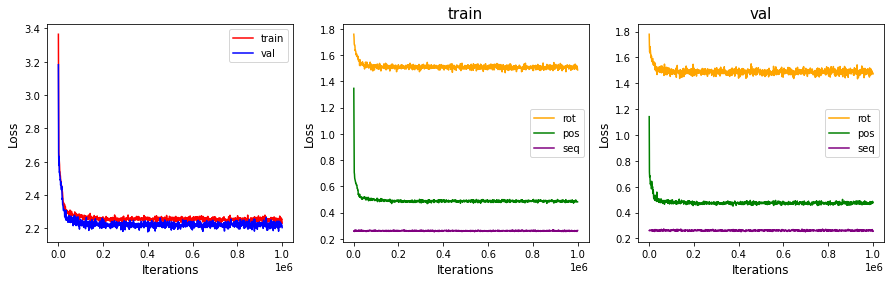

wd = 0.05
Coverged at Iter 894000 (3.394600).
train: loss=3.4966; rot=1.1180; pos=2.0213; seq=0.3573
for overleaf: 3.497 & 1.118 & 2.021 & 0.357
val: loss=3.3946; rot=1.7775; pos=1.3597; seq=0.2575
for overleaf: 3.395 & 1.778 & 1.360 & 0.258


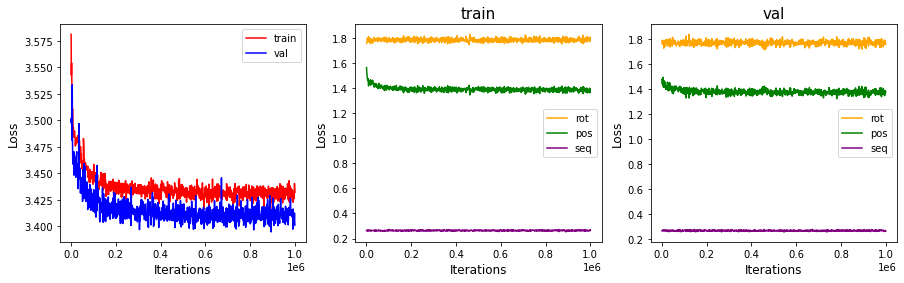

In [358]:
iter_sele_dict = model_stat(
    model_list = model_list, 
    version_list = version_list, 
    title = title, 
    log_path = LOG_PATH, 
    loss_type_list = ['rot', 'pos', 'seq'], 
    iter_sele_dict = iter_sele_dict, 
    interval = interval
)

**Conclusion**\
wd=0.0 selected with the lowest vali loss of 1.6081 at Iter458000. (wd = 0, step = 100)

## Steps

In [359]:
title = 'step'
version_list = ['1', '2', '3', '4', '5', '10', '50', '100', '500', '1000']

model_list = [
    'codesign_diffab_complete_gen_share-true_step1_lr1.e-4_wd0.0_2023_12_15__00_50_03',
    'codesign_diffab_complete_gen_share-true_step2_lr1.e-4_wd0.0_2023_12_15__00_50_03',
    'codesign_diffab_complete_gen_share-true_step3_lr1.e-4_wd0.0_2023_12_15__00_50_03',
    'codesign_diffab_complete_gen_share-true_step4_lr1.e-4_wd0.0_2023_12_15__00_50_03',
    'codesign_diffab_complete_gen_share-true_step5_lr1.e-4_wd0.0_2023_12_15__00_50_03',
    'codesign_diffab_complete_gen_share-true_step10_lr1.e-4_wd0.0_2023_05_01__17_18_33',
    'codesign_diffab_complete_gen_share-true_step50_lr1.e-4_wd0.0_2023_05_01__17_18_33',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step500_lr1.e-4_wd0.0_2023_05_01__17_18_33',
    'codesign_diffab_complete_gen_share-true_step1000_lr1.e-4_wd0.0_2023_05_01__17_05_48'
]

step = 1
Coverged at Iter 551000 (2.988400).
train: loss=2.8920; rot=-0.0000; pos=2.8920; seq=0.0000
for overleaf: 2.892 & -0.000 & 2.892 & 0.000
val: loss=2.9884; rot=0.0000; pos=2.9884; seq=0.0000
for overleaf: 2.988 & 0.000 & 2.988 & 0.000


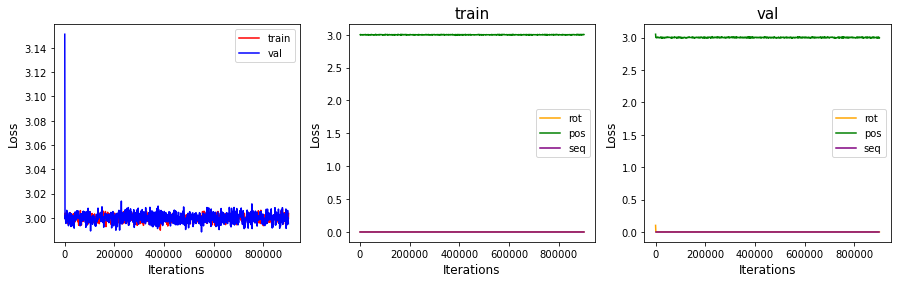

step = 2
Coverged at Iter 226000 (2.338900).
train: loss=2.9249; rot=0.0000; pos=2.9249; seq=0.0000
for overleaf: 2.925 & 0.000 & 2.925 & 0.000
val: loss=2.3389; rot=0.5115; pos=1.5763; seq=0.2511
for overleaf: 2.339 & 0.511 & 1.576 & 0.251


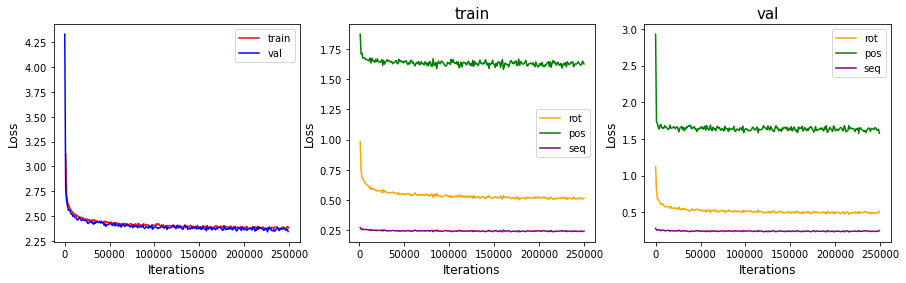

step = 3
Coverged at Iter 504000 (2.054700).
train: loss=2.1877; rot=0.8553; pos=1.1368; seq=0.1956
for overleaf: 2.188 & 0.855 & 1.137 & 0.196
val: loss=2.0547; rot=0.7365; pos=1.0830; seq=0.2351
for overleaf: 2.055 & 0.737 & 1.083 & 0.235


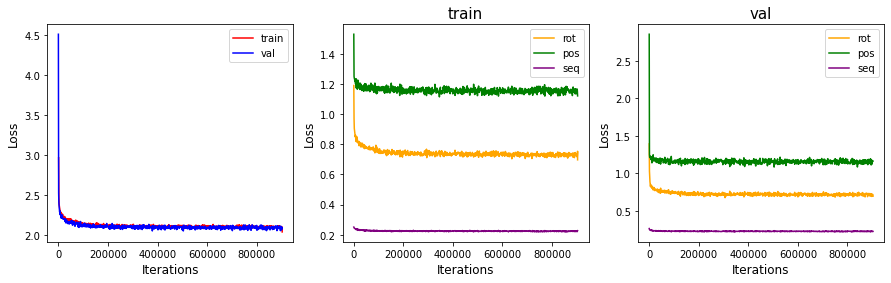

step = 4
Coverged at Iter 787000 (1.938300).
train: loss=1.2751; rot=0.4265; pos=0.5841; seq=0.2645
for overleaf: 1.275 & 0.426 & 0.584 & 0.265
val: loss=1.9383; rot=0.8205; pos=0.8882; seq=0.2296
for overleaf: 1.938 & 0.821 & 0.888 & 0.230


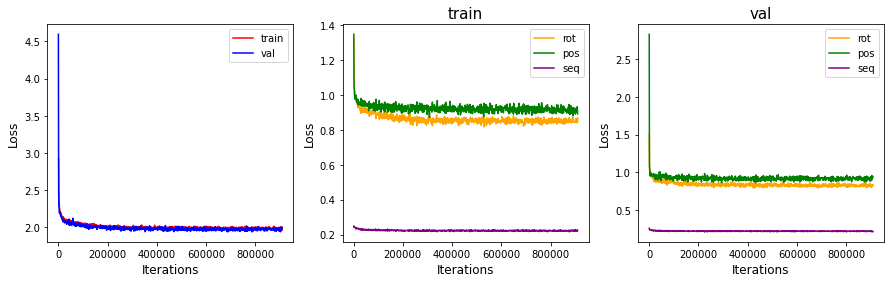

step = 5
Coverged at Iter 847000 (1.863500).
train: loss=2.0891; rot=0.2892; pos=1.6456; seq=0.1543
for overleaf: 2.089 & 0.289 & 1.646 & 0.154
val: loss=1.8635; rot=0.8882; pos=0.7441; seq=0.2312
for overleaf: 1.863 & 0.888 & 0.744 & 0.231


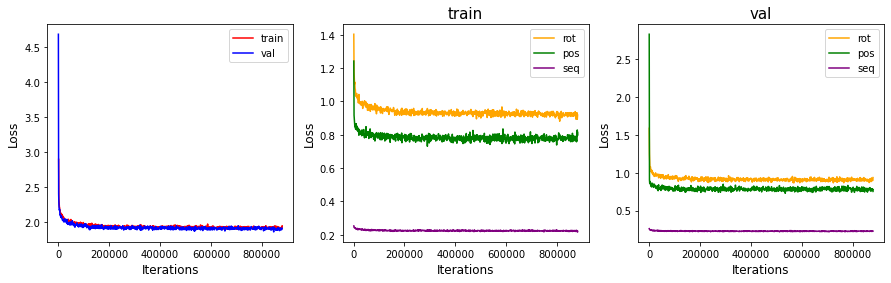

step = 10
Coverged at Iter 771000 (1.737300).
train: loss=1.6305; rot=0.7962; pos=0.6958; seq=0.1385
for overleaf: 1.631 & 0.796 & 0.696 & 0.139
val: loss=1.7373; rot=1.0404; pos=0.4652; seq=0.2316
for overleaf: 1.737 & 1.040 & 0.465 & 0.232


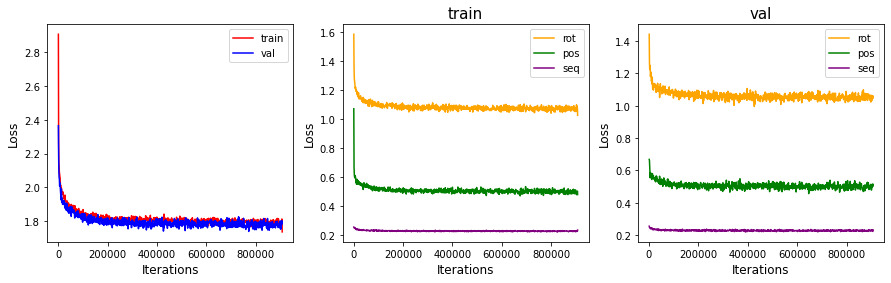

step = 50
Coverged at Iter 960000 (1.624600).
train: loss=1.4654; rot=1.0213; pos=0.2578; seq=0.1863
for overleaf: 1.465 & 1.021 & 0.258 & 0.186
val: loss=1.6246; rot=1.1058; pos=0.2837; seq=0.2351
for overleaf: 1.625 & 1.106 & 0.284 & 0.235


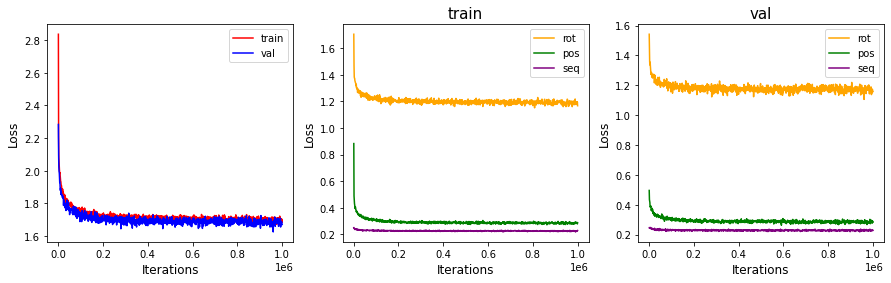

step = 100
Coverged at Iter 458000 (1.608100).
train: loss=1.5579; rot=1.1359; pos=0.2059; seq=0.2160
for overleaf: 1.558 & 1.136 & 0.206 & 0.216
val: loss=1.6081; rot=1.1153; pos=0.2573; seq=0.2355
for overleaf: 1.608 & 1.115 & 0.257 & 0.235


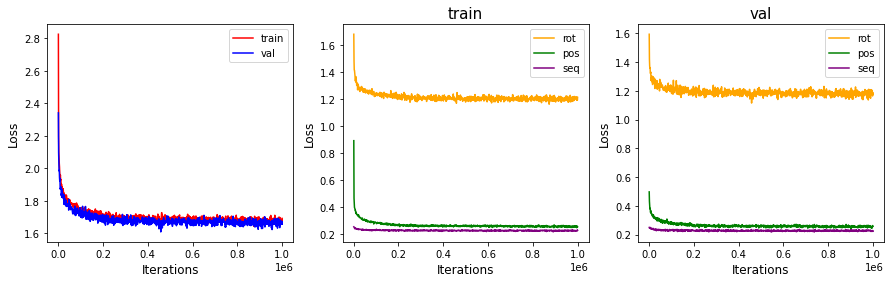

step = 500
Coverged at Iter 736000 (1.630700).
train: loss=2.5006; rot=1.9325; pos=0.2766; seq=0.2914
for overleaf: 2.501 & 1.933 & 0.277 & 0.291
val: loss=1.6307; rot=1.1550; pos=0.2455; seq=0.2301
for overleaf: 1.631 & 1.155 & 0.245 & 0.230


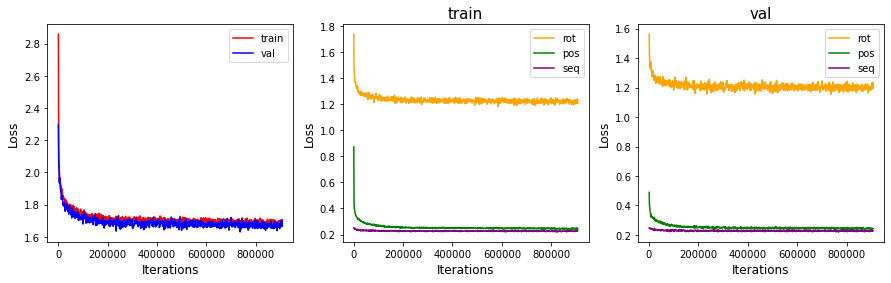

step = 1000
Coverged at Iter 725000 (1.632100).
train: loss=1.8677; rot=1.4140; pos=0.1867; seq=0.2671
for overleaf: 1.868 & 1.414 & 0.187 & 0.267
val: loss=1.6321; rot=1.1579; pos=0.2410; seq=0.2333
for overleaf: 1.632 & 1.158 & 0.241 & 0.233


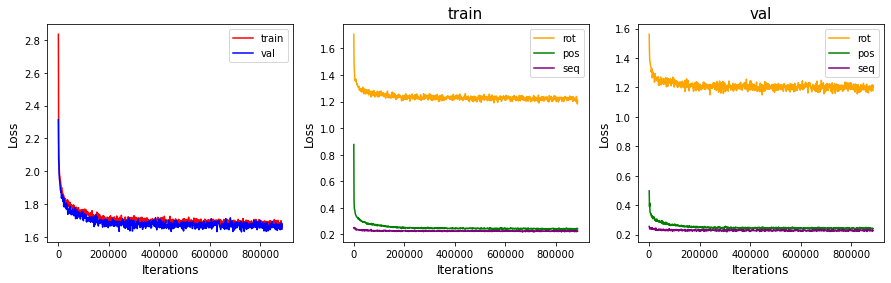

In [360]:
iter_sele_dict = model_stat(
    model_list = model_list, 
    version_list = version_list, 
    title = title, 
    log_path = LOG_PATH, 
    loss_type_list = ['rot', 'pos', 'seq'], 
    iter_sele_dict = iter_sele_dict, 
    interval = interval
)

**Conclusion** \
Got the best performance with 100 steps. Less steps would obviously increase the validation loss but more steps did not help (with a little worse performance).

## Scaling Weight

In [361]:
title = 'scaling_weight'
version_list = ['1.0', '2.2', '4.4', '5.0', '8.8', '10', '17.6', '20.0', '50.0', '100,0']

model_list = [
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale1.0_2024_01_20__16_37_11',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale2.2_2024_01_13__14_05_12',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale4.4_2024_01_13__14_05_12',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale5.0_2024_01_20__16_37_11',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale8.8_2024_01_13__14_05_12',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale17.6_2024_01_13__14_25_06',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale20.0_2024_01_20__16_37_11',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale50.0_2024_01_20__16_37_11',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale100.0_2024_01_20__16_37_11'
]

scaling_weight = 1.0
Coverged at Iter 882000 (1.564000).
train: loss=1.5903; rot=0.2825; pos=1.0985; seq=0.2092
for overleaf: 1.590 & 0.282 & 1.099 & 0.209
val: loss=1.5640; rot=0.4694; pos=0.8754; seq=0.2192
for overleaf: 1.564 & 0.469 & 0.875 & 0.219


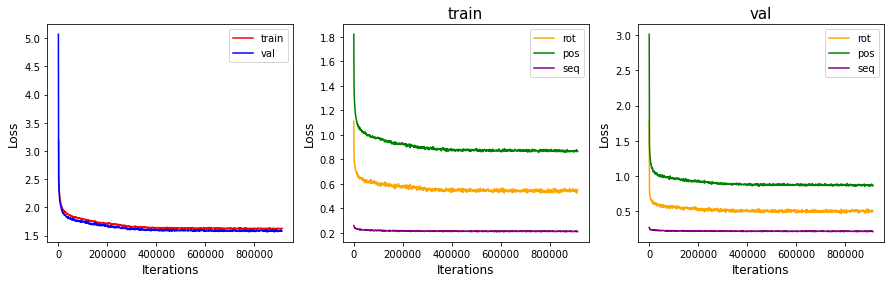

scaling_weight = 2.2
Coverged at Iter 841000 (1.560900).
train: loss=1.4043; rot=0.4517; pos=0.6446; seq=0.3080
for overleaf: 1.404 & 0.452 & 0.645 & 0.308
val: loss=1.5609; rot=0.7288; pos=0.6064; seq=0.2257
for overleaf: 1.561 & 0.729 & 0.606 & 0.226


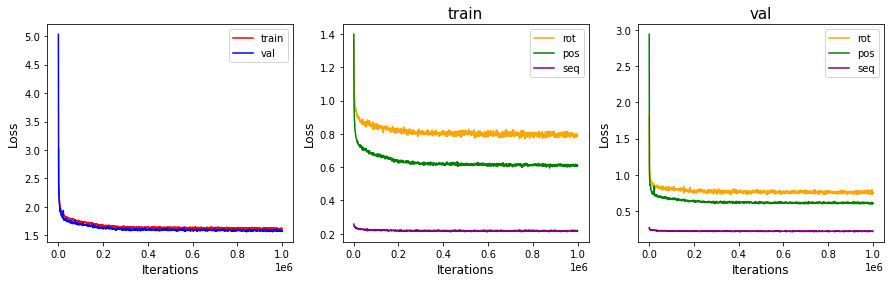

scaling_weight = 4.4
Coverged at Iter 998000 (1.596700).
train: loss=1.8148; rot=1.3007; pos=0.3708; seq=0.1432
for overleaf: 1.815 & 1.301 & 0.371 & 0.143
val: loss=1.5967; rot=0.9462; pos=0.4277; seq=0.2228
for overleaf: 1.597 & 0.946 & 0.428 & 0.223


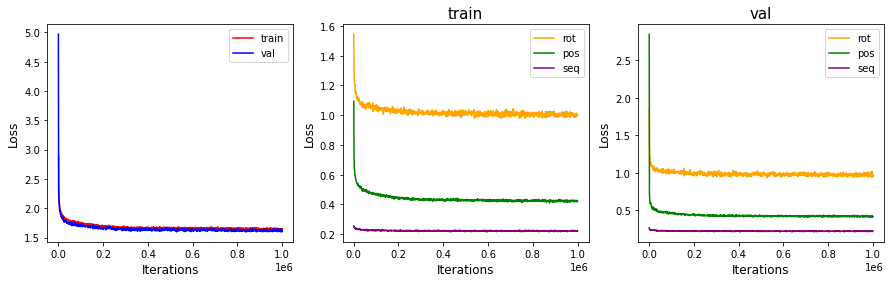

scaling_weight = 5.0
Coverged at Iter 783000 (1.587700).
train: loss=1.8412; rot=1.3555; pos=0.2943; seq=0.1913
for overleaf: 1.841 & 1.355 & 0.294 & 0.191
val: loss=1.5877; rot=0.9570; pos=0.4007; seq=0.2301
for overleaf: 1.588 & 0.957 & 0.401 & 0.230


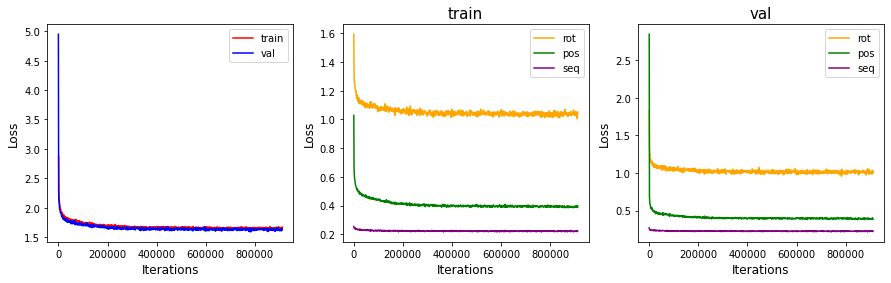

scaling_weight = 8.8
Coverged at Iter 212000 (1.618200).
train: loss=1.7127; rot=1.2240; pos=0.2226; seq=0.2662
for overleaf: 1.713 & 1.224 & 0.223 & 0.266
val: loss=1.6182; rot=1.0963; pos=0.2914; seq=0.2305
for overleaf: 1.618 & 1.096 & 0.291 & 0.231


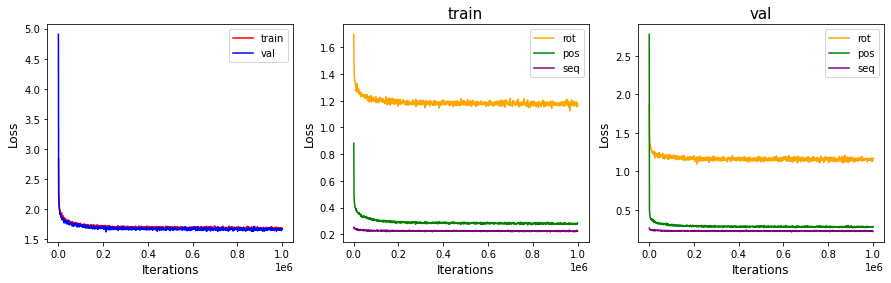

scaling_weight = 10
Coverged at Iter 458000 (1.608100).
train: loss=1.5579; rot=1.1359; pos=0.2059; seq=0.2160
for overleaf: 1.558 & 1.136 & 0.206 & 0.216
val: loss=1.6081; rot=1.1153; pos=0.2573; seq=0.2355
for overleaf: 1.608 & 1.115 & 0.257 & 0.235


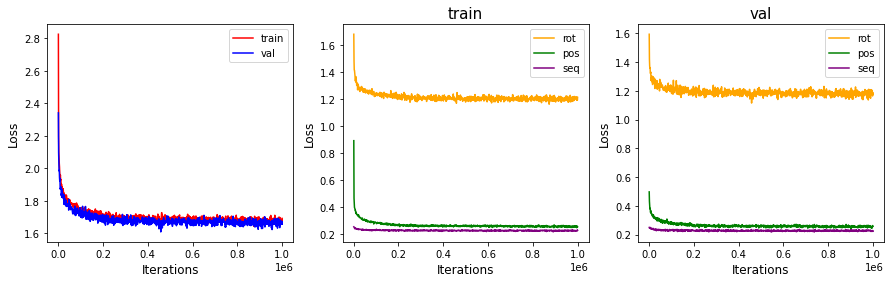

scaling_weight = 17.6
Coverged at Iter 783000 (1.658400).
train: loss=1.8990; rot=1.5971; pos=0.1078; seq=0.1942
for overleaf: 1.899 & 1.597 & 0.108 & 0.194
val: loss=1.6584; rot=1.2353; pos=0.1879; seq=0.2351
for overleaf: 1.658 & 1.235 & 0.188 & 0.235


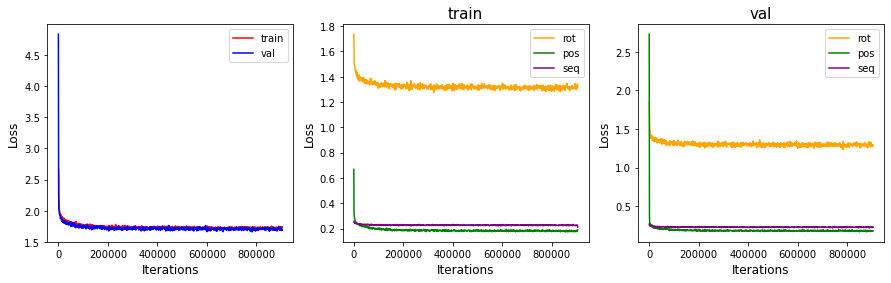

scaling_weight = 20.0
Coverged at Iter 783000 (1.662200).
train: loss=1.8887; rot=1.6026; pos=0.0927; seq=0.1934
for overleaf: 1.889 & 1.603 & 0.093 & 0.193
val: loss=1.6622; rot=1.2546; pos=0.1723; seq=0.2353
for overleaf: 1.662 & 1.255 & 0.172 & 0.235


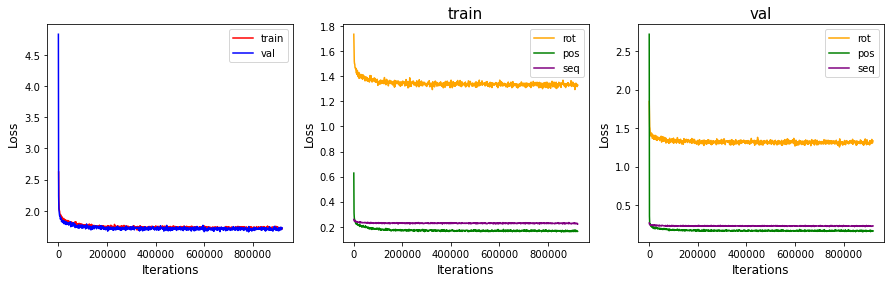

scaling_weight = 50.0
Coverged at Iter 600000 (1.679900).
train: loss=2.2383; rot=1.9669; pos=0.0697; seq=0.2016
for overleaf: 2.238 & 1.967 & 0.070 & 0.202
val: loss=1.6799; rot=1.3502; pos=0.0987; seq=0.2310
for overleaf: 1.680 & 1.350 & 0.099 & 0.231


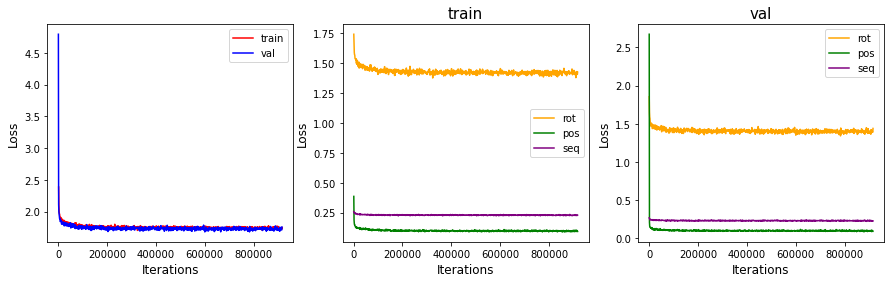

scaling_weight = 100,0
Coverged at Iter 600000 (1.678200).
train: loss=2.2398; rot=1.9819; pos=0.0544; seq=0.2036
for overleaf: 2.240 & 1.982 & 0.054 & 0.204
val: loss=1.6782; rot=1.3706; pos=0.0761; seq=0.2316
for overleaf: 1.678 & 1.371 & 0.076 & 0.232


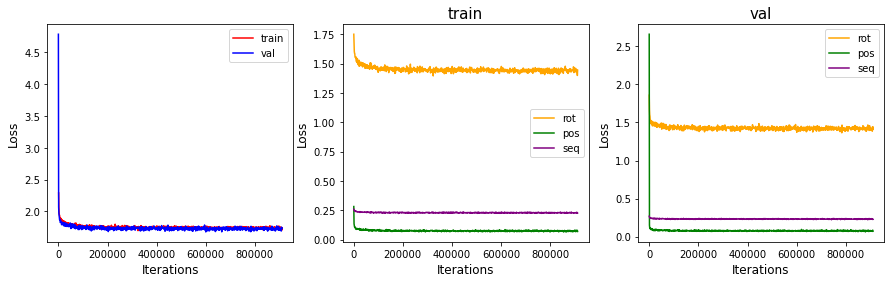

In [362]:
iter_sele_dict = model_stat(
    model_list = model_list, 
    version_list = version_list, 
    title = title, 
    log_path = LOG_PATH, 
    loss_type_list = ['rot', 'pos', 'seq'], 
    iter_sele_dict = iter_sele_dict, 
    interval = interval
)

### Larger Models

layers = 3
Coverged at Iter 928000 (1.663000).
train: loss=1.3803; rot=0.8795; pos=0.2867; seq=0.2142
for overleaf: 1.380 & 0.879 & 0.287 & 0.214
val: loss=1.6630; rot=1.1588; pos=0.2738; seq=0.2304
for overleaf: 1.663 & 1.159 & 0.274 & 0.230


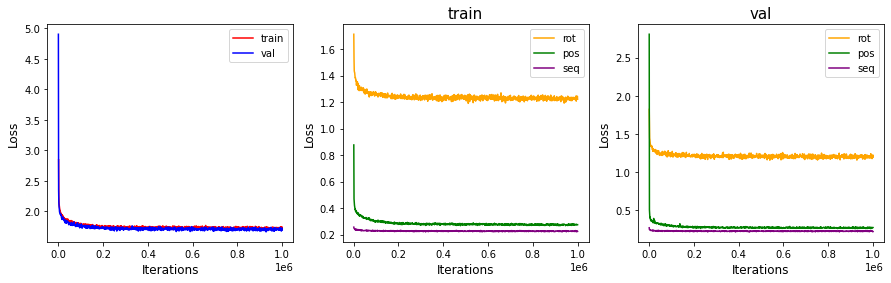

layers = 6
Coverged at Iter 458000 (1.608100).
train: loss=1.5579; rot=1.1359; pos=0.2059; seq=0.2160
for overleaf: 1.558 & 1.136 & 0.206 & 0.216
val: loss=1.6081; rot=1.1153; pos=0.2573; seq=0.2355
for overleaf: 1.608 & 1.115 & 0.257 & 0.235


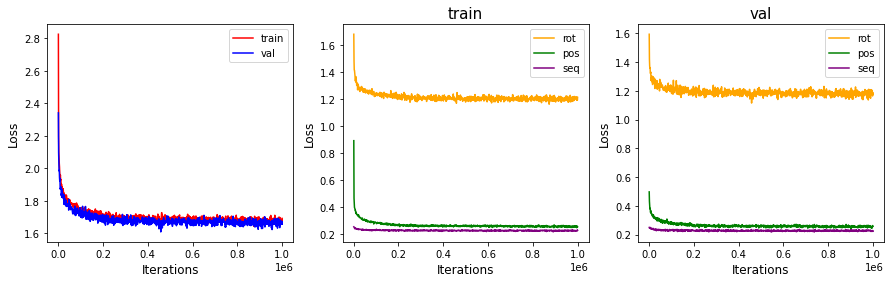

layers = 9
Coverged at Iter 574000 (1.615200).
train: loss=1.3018; rot=0.7332; pos=0.2314; seq=0.3372
for overleaf: 1.302 & 0.733 & 0.231 & 0.337
val: loss=1.6152; rot=1.1322; pos=0.2523; seq=0.2307
for overleaf: 1.615 & 1.132 & 0.252 & 0.231


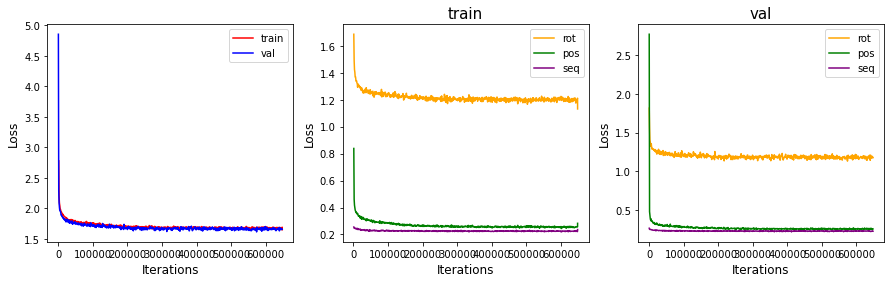

layers = 12
Coverged at Iter 427000 (1.622400).
train: loss=1.9543; rot=1.6567; pos=0.1420; seq=0.1556
for overleaf: 1.954 & 1.657 & 0.142 & 0.156
val: loss=1.6224; rot=1.1360; pos=0.2554; seq=0.2310
for overleaf: 1.622 & 1.136 & 0.255 & 0.231


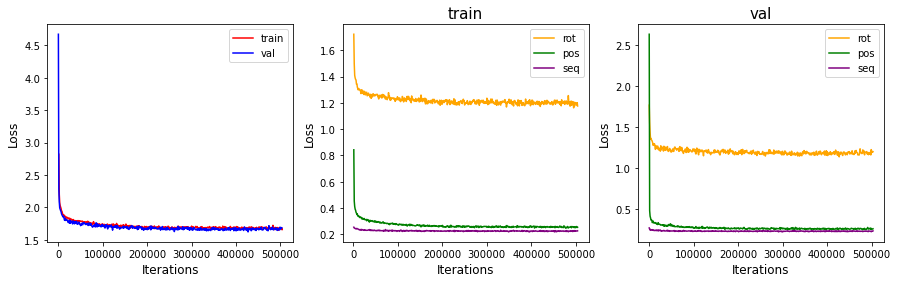

In [363]:
title = 'layers'
version_list = ['3', '6', '9', '12']

model_list = [
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_3layers_2024_01_20__16_37_11',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_9layers_2024_01_20__16_37_11',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_12layers_2024_01_20__16_37_11'
]

iter_sele_dict = model_stat(
    model_list = model_list, 
    version_list = version_list, 
    title = title, 
    log_path = LOG_PATH, 
    loss_type_list = ['rot', 'pos', 'seq'], 
    iter_sele_dict = iter_sele_dict, 
    interval = interval
)

resi_dim = 128
Coverged at Iter 458000 (1.608100).
train: loss=1.5579; rot=1.1359; pos=0.2059; seq=0.2160
for overleaf: 1.558 & 1.136 & 0.206 & 0.216
val: loss=1.6081; rot=1.1153; pos=0.2573; seq=0.2355
for overleaf: 1.608 & 1.115 & 0.257 & 0.235


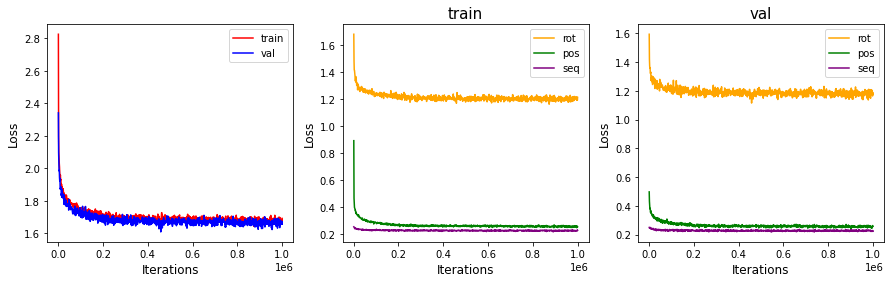

resi_dim = 256
Coverged at Iter 769000 (1.619900).
train: loss=1.3776; rot=0.8747; pos=0.2739; seq=0.2290
for overleaf: 1.378 & 0.875 & 0.274 & 0.229
val: loss=1.6199; rot=1.1400; pos=0.2507; seq=0.2292
for overleaf: 1.620 & 1.140 & 0.251 & 0.229


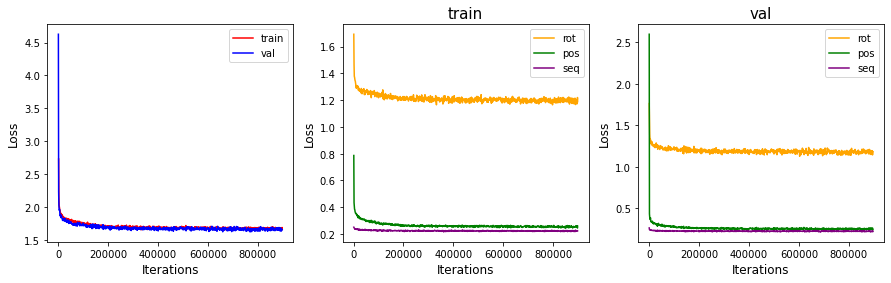

resi_dim = 512
Coverged at Iter 794000 (1.617900).
train: loss=1.8908; rot=1.4879; pos=0.2039; seq=0.1990
for overleaf: 1.891 & 1.488 & 0.204 & 0.199
val: loss=1.6179; rot=1.1297; pos=0.2588; seq=0.2295
for overleaf: 1.618 & 1.130 & 0.259 & 0.230


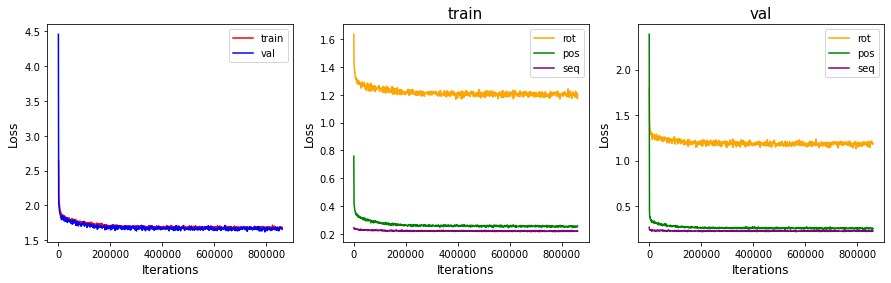

In [364]:
title = 'resi_dim'
version_list = ['128', '256', '512']

model_list = [
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_resi256_2024_01_20__16_37_11',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_resi512_2024_01_20__16_37_11'
]

iter_sele_dict = model_stat(
    model_list = model_list, 
    version_list = version_list, 
    title = title, 
    log_path = LOG_PATH, 
    loss_type_list = ['rot', 'pos', 'seq'], 
    iter_sele_dict = iter_sele_dict, 
    interval = interval
)

pair_dim = 64
Coverged at Iter 458000 (1.608100).
train: loss=1.5579; rot=1.1359; pos=0.2059; seq=0.2160
for overleaf: 1.558 & 1.136 & 0.206 & 0.216
val: loss=1.6081; rot=1.1153; pos=0.2573; seq=0.2355
for overleaf: 1.608 & 1.115 & 0.257 & 0.235


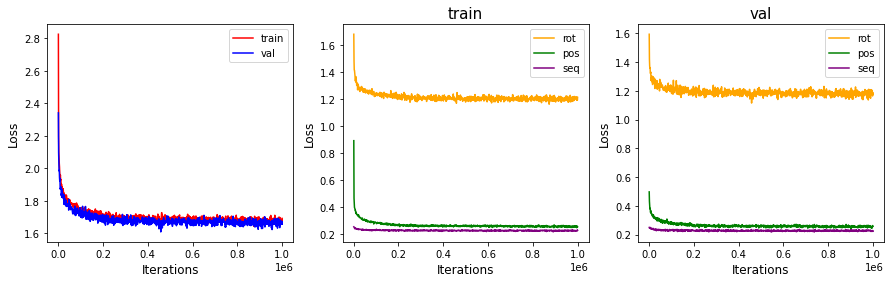

pair_dim = 128
Coverged at Iter 677000 (1.626800).
train: loss=1.0625; rot=0.5034; pos=0.2451; seq=0.3139
for overleaf: 1.062 & 0.503 & 0.245 & 0.314
val: loss=1.6268; rot=1.1437; pos=0.2560; seq=0.2271
for overleaf: 1.627 & 1.144 & 0.256 & 0.227


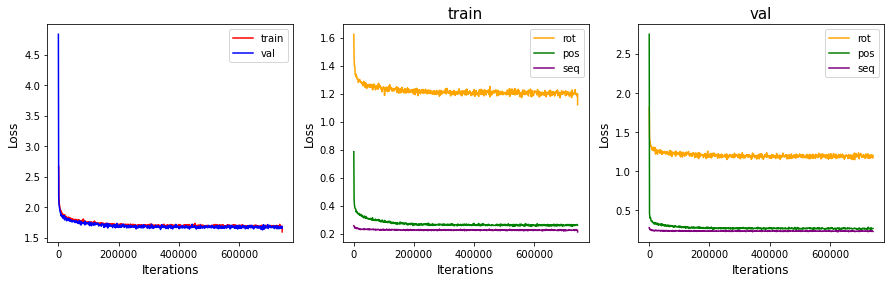

pair_dim = 256
Coverged at Iter 848000 (1.664300).
train: loss=1.0060; rot=0.4018; pos=0.2924; seq=0.3118
for overleaf: 1.006 & 0.402 & 0.292 & 0.312
val: loss=1.6643; rot=1.1493; pos=0.2868; seq=0.2282
for overleaf: 1.664 & 1.149 & 0.287 & 0.228


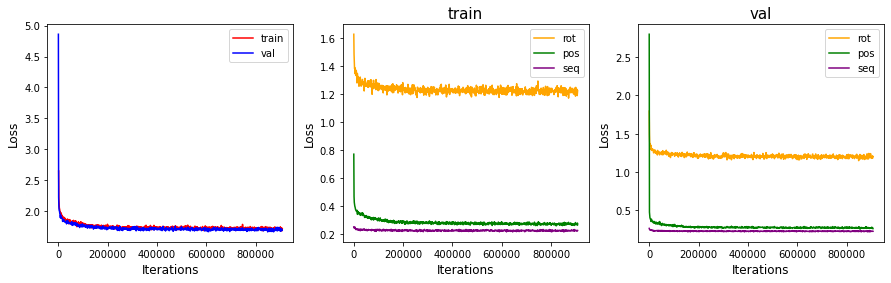

pair_dim = 512
Coverged at Iter 859000 (1.703200).
train: loss=1.6594; rot=1.0499; pos=0.2321; seq=0.3774
for overleaf: 1.659 & 1.050 & 0.232 & 0.377
val: loss=1.7032; rot=1.1801; pos=0.2867; seq=0.2364
for overleaf: 1.703 & 1.180 & 0.287 & 0.236


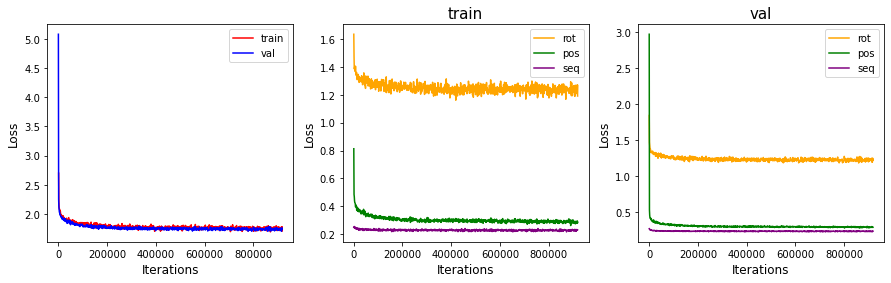

In [365]:
title = 'pair_dim'
version_list = ['64', '128', '256', '512']

model_list = [
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_pair128_2024_01_20__16_37_11',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_pair256_2024_01_24__22_52_59',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_pair512_2024_01_24__22_52_59'
]

iter_sele_dict = model_stat(
    model_list = model_list, 
    version_list = version_list, 
    title = title, 
    log_path = LOG_PATH, 
    loss_type_list = ['rot', 'pos', 'seq'], 
    iter_sele_dict = iter_sele_dict, 
    interval = interval
)

merged = 6-128-64
Coverged at Iter 458000 (1.608100).
train: loss=1.5579; rot=1.1359; pos=0.2059; seq=0.2160
for overleaf: 1.558 & 1.136 & 0.206 & 0.216
val: loss=1.6081; rot=1.1153; pos=0.2573; seq=0.2355
for overleaf: 1.608 & 1.115 & 0.257 & 0.235


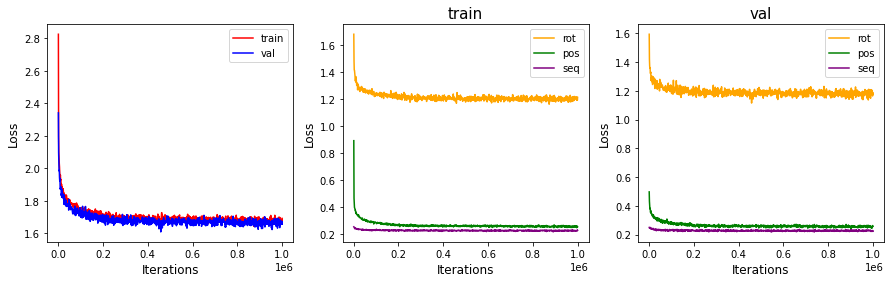

merged = 12-128-64
Coverged at Iter 433000 (1.611500).
train: loss=1.6812; rot=1.2983; pos=0.1939; seq=0.1890
for overleaf: 1.681 & 1.298 & 0.194 & 0.189
val: loss=1.6115; rot=1.1201; pos=0.2633; seq=0.2281
for overleaf: 1.611 & 1.120 & 0.263 & 0.228


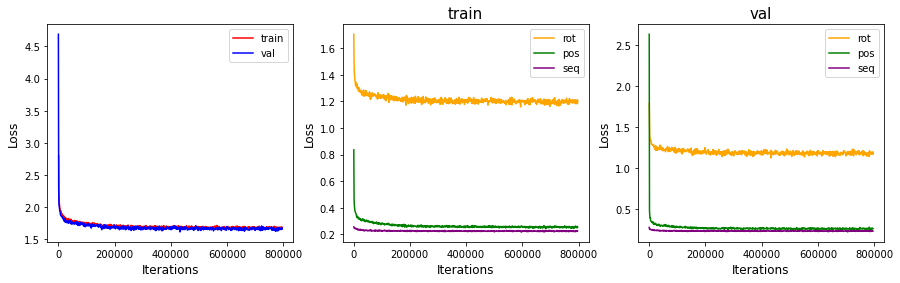

merged = 6-256-128
Coverged at Iter 785000 (1.612800).
train: loss=1.2614; rot=0.8066; pos=0.2375; seq=0.2173
for overleaf: 1.261 & 0.807 & 0.237 & 0.217
val: loss=1.6128; rot=1.1237; pos=0.2623; seq=0.2269
for overleaf: 1.613 & 1.124 & 0.262 & 0.227


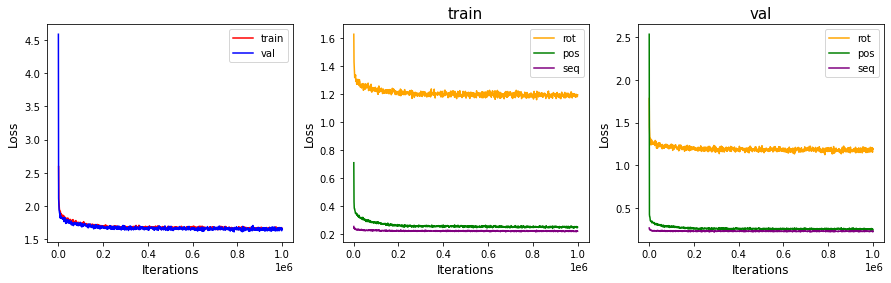

merged = 6-512-256
Coverged at Iter 816000 (1.612800).
train: loss=2.4157; rot=2.1522; pos=0.1530; seq=0.1106
for overleaf: 2.416 & 2.152 & 0.153 & 0.111
val: loss=1.6128; rot=1.1360; pos=0.2535; seq=0.2232
for overleaf: 1.613 & 1.136 & 0.254 & 0.223


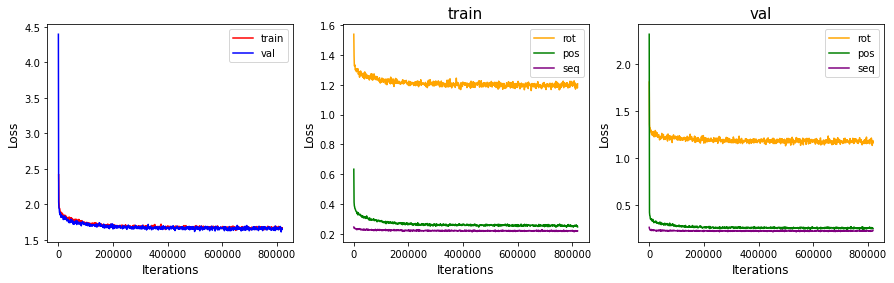

In [366]:
title = 'merged'
version_list = ['6-128-64', '12-128-64', '6-256-128', '6-512-256']

model_list = [
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_large-1_2024_01_13__14_21_50',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_large-2_2024_01_13__14_21_50',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_large-3_2024_01_13__14_21_50'
]

iter_sele_dict = model_stat(
    model_list = model_list, 
    version_list = version_list, 
    title = title, 
    log_path = LOG_PATH, 
    loss_type_list = ['rot', 'pos', 'seq'], 
    iter_sele_dict = iter_sele_dict, 
    interval = interval
)

### Combined

Step = 5
Coverged at Iter 732000 (1.883500).
train: loss=2.0717; rot=0.5779; pos=1.3538; seq=0.1401
for overleaf: 2.072 & 0.578 & 1.354 & 0.140
val: loss=1.8835; rot=0.9990; pos=0.6530; seq=0.2316
for overleaf: 1.883 & 0.999 & 0.653 & 0.232


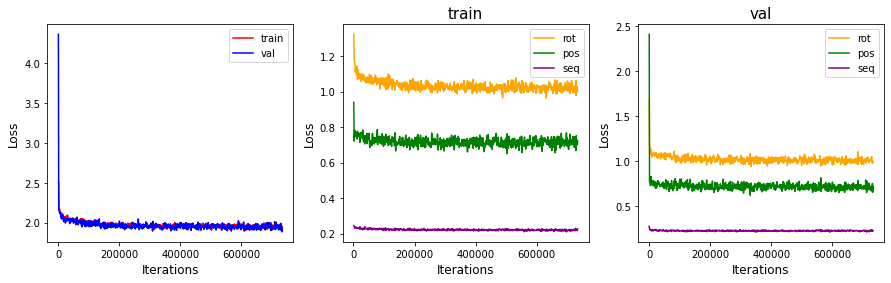

Step = 10
Coverged at Iter 696000 (1.734300).
train: loss=1.3469; rot=0.2327; pos=0.9461; seq=0.1681
for overleaf: 1.347 & 0.233 & 0.946 & 0.168
val: loss=1.7343; rot=1.0818; pos=0.4216; seq=0.2309
for overleaf: 1.734 & 1.082 & 0.422 & 0.231


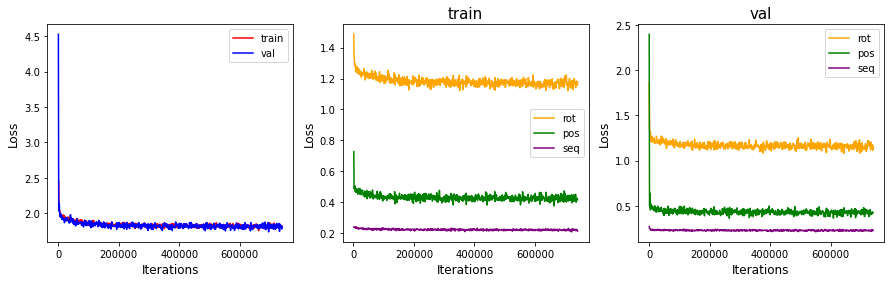

Step = 100
Coverged at Iter 558000 (1.639800).
train: loss=1.5229; rot=0.9669; pos=0.1537; seq=0.4024
for overleaf: 1.523 & 0.967 & 0.154 & 0.402
val: loss=1.6398; rot=1.2364; pos=0.1725; seq=0.2309
for overleaf: 1.640 & 1.236 & 0.172 & 0.231


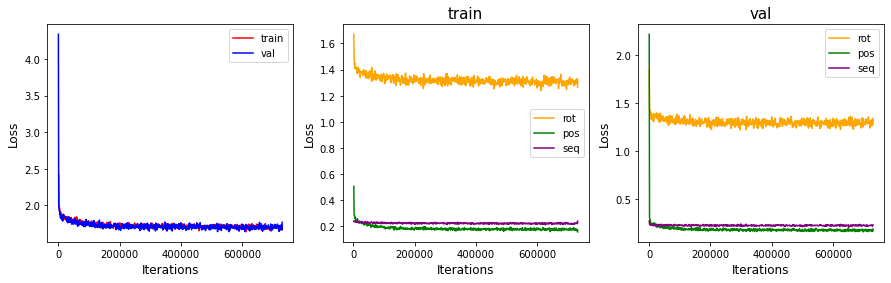

In [368]:
title = 'Step'
version_list = [5, 10, 100]

model_list = [
    'codesign_multinomial_step5_posiscale17.6_6-512-256_2024_02_01__00_55_13',
    'codesign_multinomial_step10_posiscale17.6_6-512-256_2024_02_01__00_55_13',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_2024_02_01__00_55_13'
]

loss_type_list_all = [
    ['rot', 'pos', 'seq'],
    ['rot', 'pos', 'seq'],
    ['rot', 'pos', 'seq'],
]

color_list_all = [
    ['red', 'blue', 'orange', 'green', 'purple'],
    ['red', 'blue', 'orange', 'green', 'purple'],
    ['red', 'blue', 'orange', 'green', 'purple'],
]

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

### Other diffusion mechanism

Sequence Diffsion = "multinomial"
Coverged at Iter 458000 (1.608100).
train: loss=1.5579; rot=1.1359; pos=0.2059; seq=0.2160
for overleaf: 1.558 & 1.136 & 0.206 & 0.216
val: loss=1.6081; rot=1.1153; pos=0.2573; seq=0.2355
for overleaf: 1.608 & 1.115 & 0.257 & 0.235


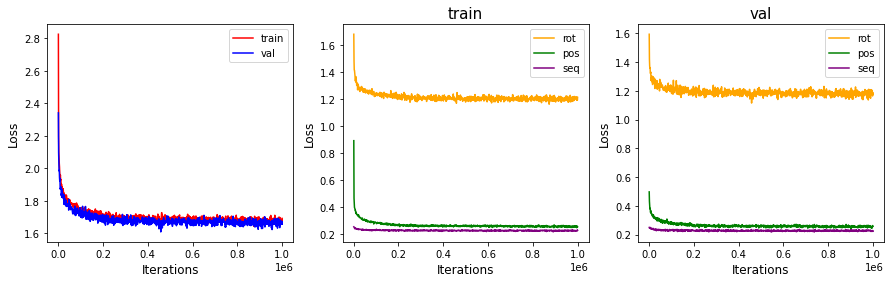

Sequence Diffsion = "discrete-random"
Coverged at Iter 104000 (20349.117200).
train: loss=27562.2109; rot=1.9404; pos=0.1331; seq=27560.1367
for overleaf: 27562.211 & 1.940 & 0.133 & 27560.137
val: loss=20349.1172; rot=1.3205; pos=0.1969; seq=20347.6016
for overleaf: 20349.117 & 1.321 & 0.197 & 20347.602


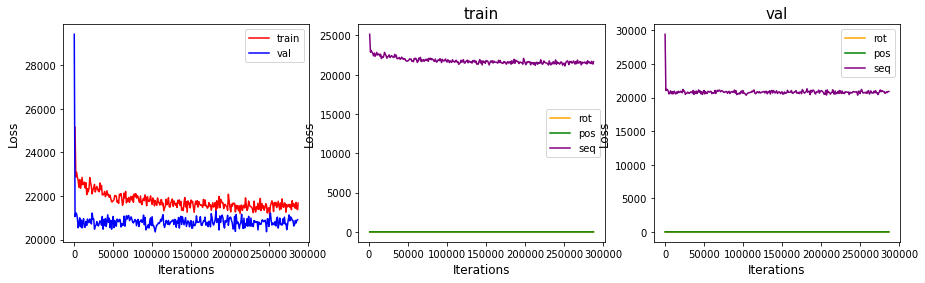

Sequence Diffsion = "discrete-blosum"
Coverged at Iter 121000 (23753.808600).
train: loss=20611.5352; rot=1.4094; pos=0.1407; seq=20609.9844
for overleaf: 20611.535 & 1.409 & 0.141 & 20609.984
val: loss=23753.8086; rot=1.2021; pos=0.1989; seq=23752.4219
for overleaf: 23753.809 & 1.202 & 0.199 & 23752.422


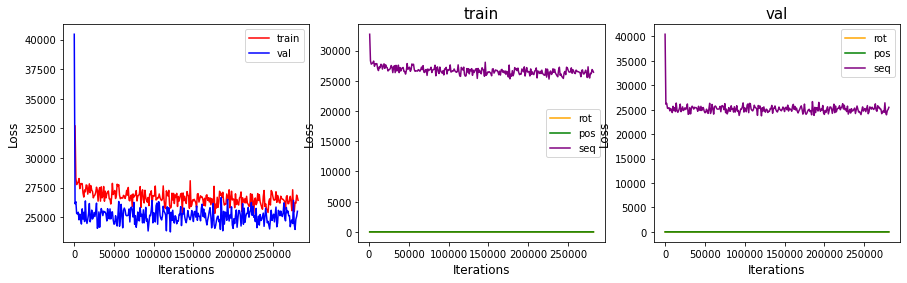

Sequence Diffsion = "autoregressive"
Coverged at Iter 48000 (1214.490000).
train: loss=1276.5569; rot=1.3712; pos=0.1463; seq=1275.0396
for overleaf: 1276.557 & 1.371 & 0.146 & 1275.040
val: loss=1214.4900; rot=1.3394; pos=0.2236; seq=1212.9270
for overleaf: 1214.490 & 1.339 & 0.224 & 1212.927


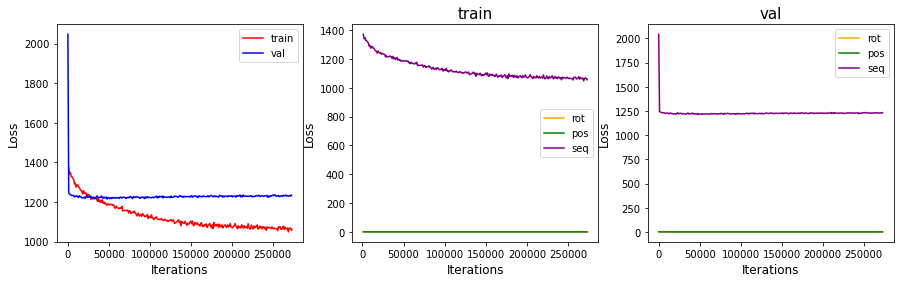

Sequence Diffsion = "autoregressive-MaskOnly"
Coverged at Iter 59000 (1215.289600).
train: loss=970.2610; rot=0.5616; pos=0.2875; seq=969.4119
for overleaf: 970.261 & 0.562 & 0.287 & 969.412
val: loss=1215.2896; rot=1.3636; pos=0.2127; seq=1213.7135
for overleaf: 1215.290 & 1.364 & 0.213 & 1213.714


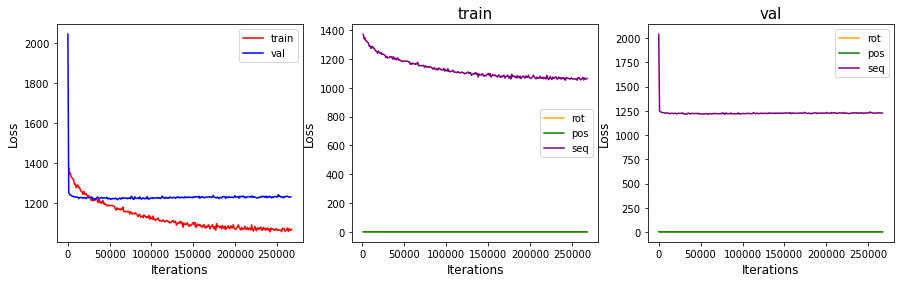

Sequence Diffsion = "autoregressive-random"
Coverged at Iter 61000 (1213.637000).
train: loss=1245.6562; rot=2.2319; pos=0.1098; seq=1243.3146
for overleaf: 1245.656 & 2.232 & 0.110 & 1243.315
val: loss=1213.6370; rot=1.3292; pos=0.2216; seq=1212.0864
for overleaf: 1213.637 & 1.329 & 0.222 & 1212.086


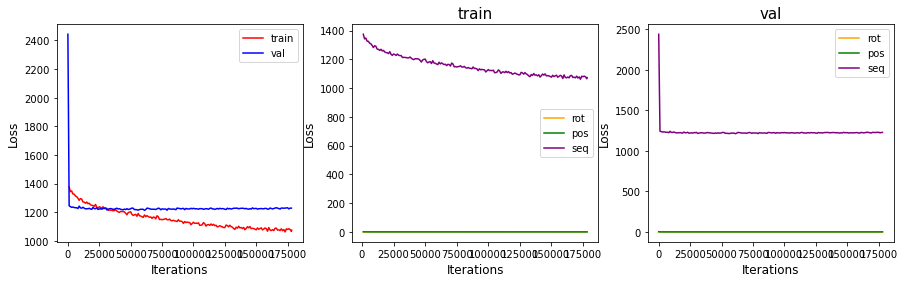

In [372]:
title = 'Sequence Diffsion'
version_list = ['"multinomial"', '"discrete-random"', '"discrete-blosum"',
               '"autoregressive"', '"autoregressive-MaskOnly"', '"autoregressive-random"']

model_list = [
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48',
    'codesign_discrete-random_posiscale17.6_2024_01_29__20_57_00',
    'codesign_discrete-blosum_posiscale17.6_2024_01_29__20_57_00',
    'codesign_autoregressive_posiscale17.6_2024_01_29__20_57_00',
    'codesign_autoregressive-maskonly_posiscale17.6_2024_01_30__13_27_49',
    'codesign_autoregressive-random_posiscale17.6_2024_01_30__13_27_49'
]

loss_type_list_all = [
    ['rot', 'pos', 'seq'],
    ['rot', 'pos', 'seq'],
    ['rot', 'pos', 'seq'],
    ['rot', 'pos', 'seq'],
    ['rot', 'pos', 'seq'],
    ['rot', 'pos', 'seq'],
]

color_list_all = [
    ['red', 'blue', 'orange', 'green', 'purple'],
    ['red', 'blue', 'orange', 'green', 'purple'],
    ['red', 'blue', 'orange', 'green', 'purple'],
    ['red', 'blue', 'orange', 'green', 'purple'],
    ['red', 'blue', 'orange', 'green', 'purple'],
    ['red', 'blue', 'orange', 'green', 'purple'],
]

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

### Ablation Study

**Sequence Only**

* Single Modality

Ablation = small-10.0
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
Coverged at Iter 297000 (0.222200).
train: loss=0.1402; seq=0.1402
for overleaf: 0.140 & 0.140
val: loss=0.2222; seq=0.2222
for overleaf: 0.222 & 0.222


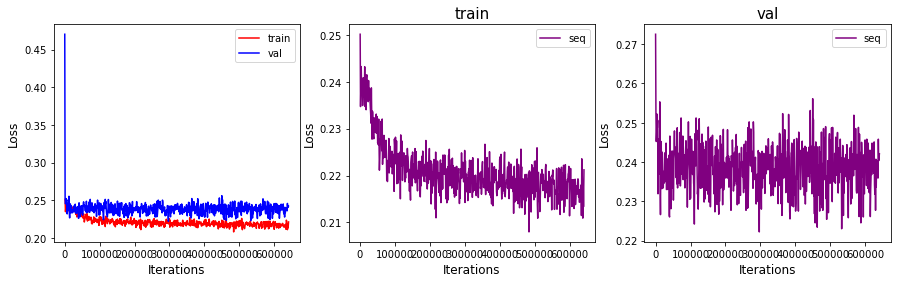

Ablation = large-10.0
Coverged at Iter 236000 (0.217800).
train: loss=0.2720; seq=0.2720
for overleaf: 0.272 & 0.272
val: loss=0.2178; seq=0.2178
for overleaf: 0.218 & 0.218


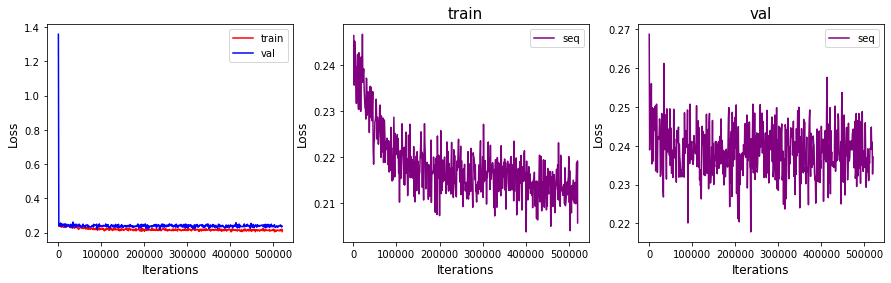

Ablation = small-17.6
Coverged at Iter 834000 (0.221900).
train: loss=0.1238; seq=0.1238
for overleaf: 0.124 & 0.124
val: loss=0.2219; seq=0.2219
for overleaf: 0.222 & 0.222


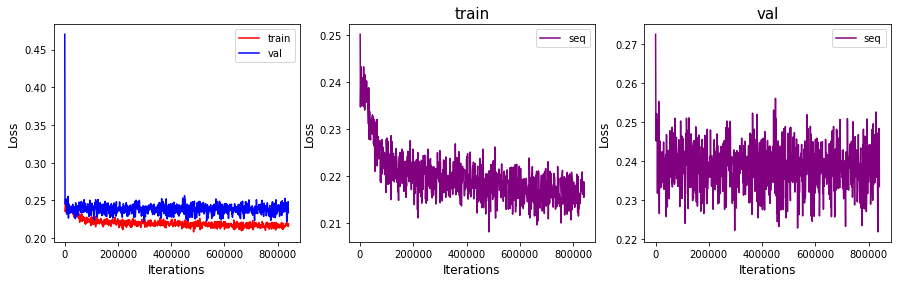

Ablation = large-17.6
Coverged at Iter 236000 (0.217800).
train: loss=0.2774; seq=0.2774
for overleaf: 0.277 & 0.277
val: loss=0.2178; seq=0.2178
for overleaf: 0.218 & 0.218


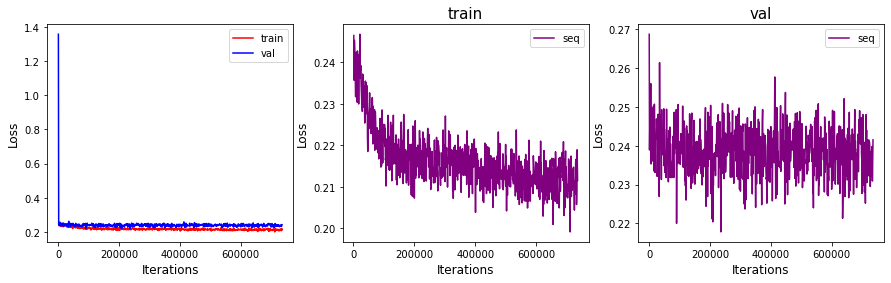

In [380]:
title = 'Ablation'
version_list = ['small-10.0', 'large-10.0', 'small-17.6', 'large-17.6']
              
model_list = [
    'codesign_multinomial_step100_posiscale10.0_6-128-64-4_sequence-modal_2024_02_16__15_13_51',
    'codesign_multinomial_step100_posiscale10.0_6-512-256-2_sequence-modal_2024_02_16__19_55_26',
    'codesign_multinomial_step100_posiscale17.6_6-128-64-4_sequence-modal_2024_02_12__20_29_24',
    'codesign_multinomial_step100_posiscale17.6_6-512-256-2_sequence-modal_2024_02_12__20_29_24',
]

loss_type_list_all = [
    ['seq']
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'purple']
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

* Given Structure

Ablation = small-10.0
Coverged at Iter 206000 (0.179600).
train: loss=0.1528; seq=0.1528
for overleaf: 0.153 & 0.153
val: loss=0.1796; seq=0.1796
for overleaf: 0.180 & 0.180


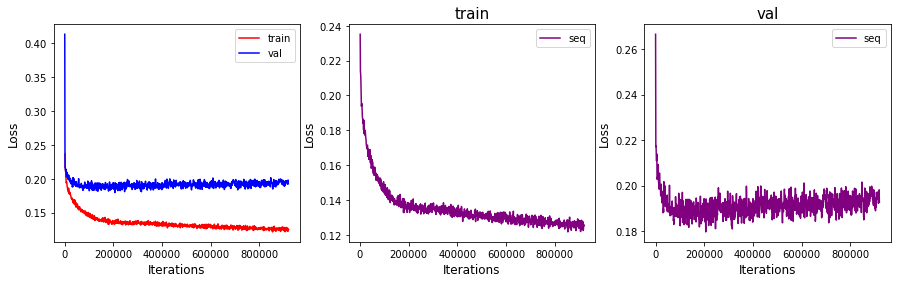

Ablation = large-10.0
Coverged at Iter 111000 (0.179300).
train: loss=0.0122; seq=0.0122
for overleaf: 0.012 & 0.012
val: loss=0.1793; seq=0.1793
for overleaf: 0.179 & 0.179


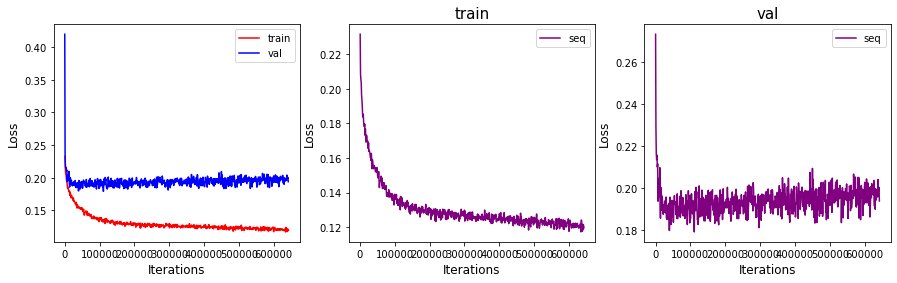

Ablation = small-17.6
Coverged at Iter 111000 (0.181600).
train: loss=0.0110; seq=0.0110
for overleaf: 0.011 & 0.011
val: loss=0.1816; seq=0.1816
for overleaf: 0.182 & 0.182


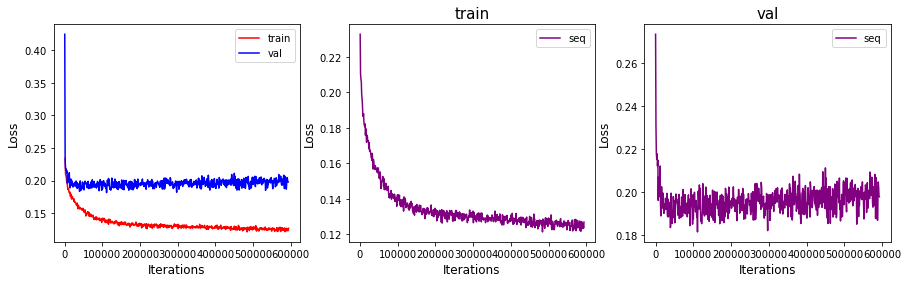

Ablation = large-17.6
Coverged at Iter 297000 (0.181000).
train: loss=0.0745; seq=0.0745
for overleaf: 0.074 & 0.074
val: loss=0.1810; seq=0.1810
for overleaf: 0.181 & 0.181


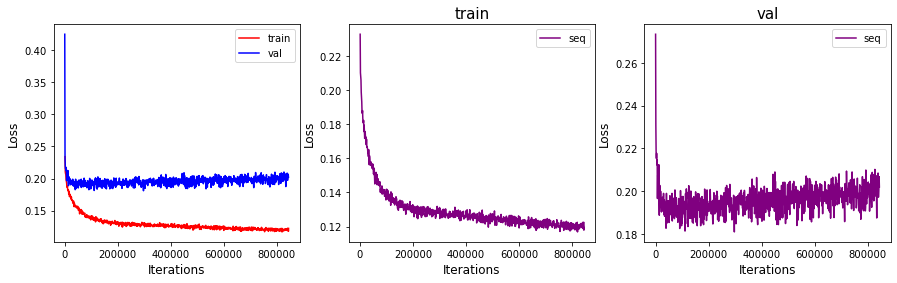

In [381]:
title = 'Ablation'
version_list = ['small-10.0', 'large-10.0', 'small-17.6', 'large-17.6']
              
model_list = [
    'codesign_origindiff_sequenceOnly_2024_01_20__16_37_11',
    'codesign_multinomial_step100_posiscale10.0_6-512-256_sequenceOnly_2024_02_16__15_13_51',
    'codesign_multinomial_step100_posiscale17.6_6-128-64-4_sequenceOnly_2024_02_16__19_55_26',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_sequenceOnly_2024_02_10__22_38_44',
]

loss_type_list_all = [
    ['seq']
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'purple']
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

* Other Diffusion Mechanism

Ablation = autoregressive
Coverged at Iter 45000 (1210.048700).
train: loss=1106.6057; seq=1106.6057
for overleaf: 1106.606 & 1106.606
val: loss=1210.0487; seq=1210.0491
for overleaf: 1210.049 & 1210.049


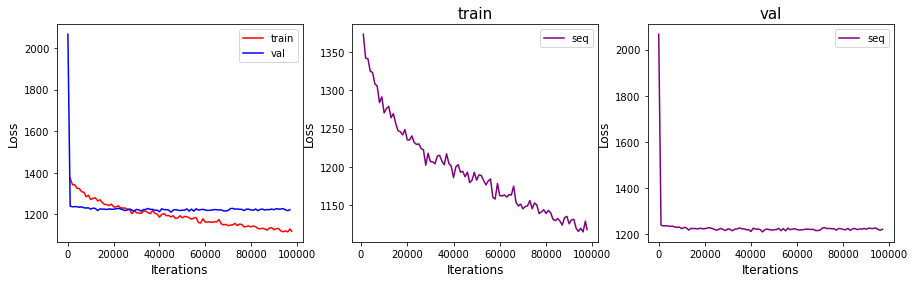

Ablation = autoregressive (mask-only)
Coverged at Iter 45000 (1212.250600).
train: loss=1103.4886; seq=1103.4886
for overleaf: 1103.489 & 1103.489
val: loss=1212.2506; seq=1212.2505
for overleaf: 1212.251 & 1212.251


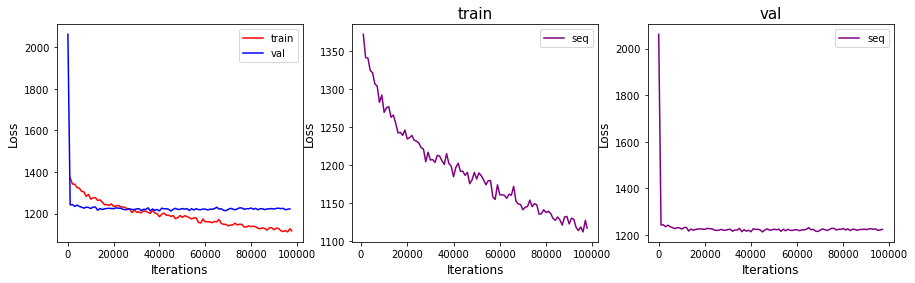

Ablation = autoregressive-random
Coverged at Iter 48000 (1210.386600).
train: loss=725.1868; seq=725.1868
for overleaf: 725.187 & 725.187
val: loss=1210.3866; seq=1210.3872
for overleaf: 1210.387 & 1210.387


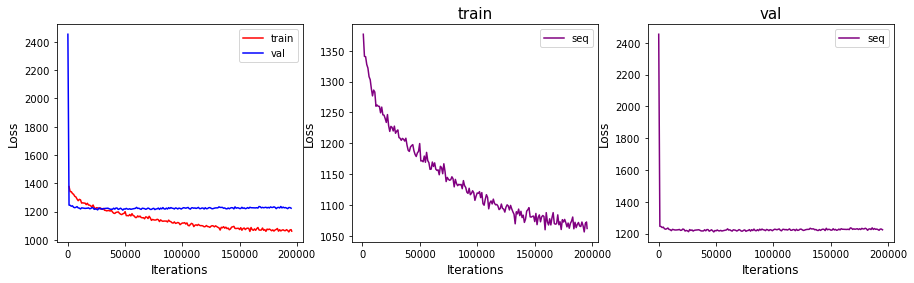

Ablation = discrete-blosum
Coverged at Iter 225000 (23013.019500).
train: loss=21533.5938; seq=21533.5938
for overleaf: 21533.594 & 21533.594
val: loss=23013.0195; seq=23013.0078
for overleaf: 23013.019 & 23013.008


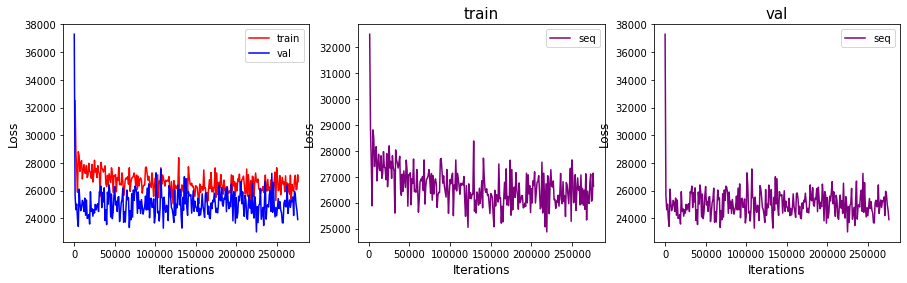

Ablation = discrete-random
Coverged at Iter 111000 (19987.347700).
train: loss=32756.5664; seq=32756.5664
for overleaf: 32756.566 & 32756.566
val: loss=19987.3477; seq=19987.3438
for overleaf: 19987.348 & 19987.344


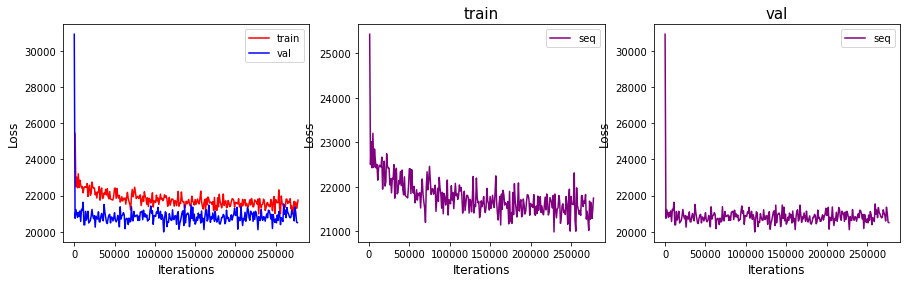

In [382]:
title = 'Ablation'
version_list = ['autoregressive', 'autoregressive (mask-only)', 'autoregressive-random',
                'discrete-blosum', 'discrete-random']

model_list = [
    'origindiff_sequenceOnly_autoregressive_2024_01_29__20_57_00',
    'origindiff_sequenceOnly_autoregressive-maskonly_2024_01_30__13_27_49',
    'origindiff_sequenceOnly_autoregressive-random_2024_01_30__13_27_49',
    'origindiff_sequenceOnly_discrete-blosum_2024_01_29__20_57_01',
    'origindiff_sequenceOnly_discrete-random_2024_01_29__20_57_00',
]

loss_type_list_all = [
    ['seq']
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'purple']
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

**Structure Only**

* Single Modality

Ablation = small-10.0
Coverged at Iter 180000 (1.405200).
train: loss=0.9427; rot=0.6279; pos=0.3147
for overleaf: 0.943 & 0.628 & 0.315
val: loss=1.4052; rot=1.1350; pos=0.2702
for overleaf: 1.405 & 1.135 & 0.270


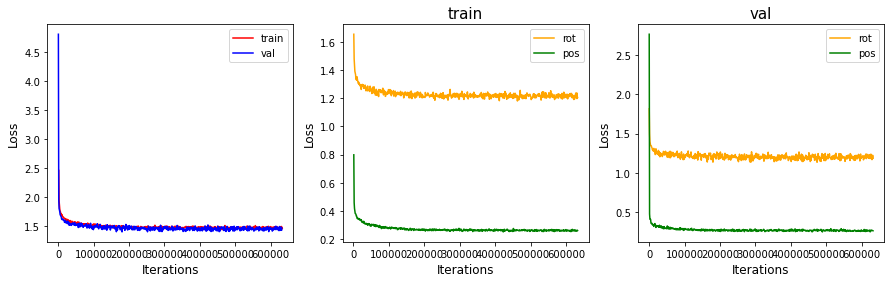

Ablation = large-10.0
Coverged at Iter 494000 (1.405000).
train: loss=2.1304; rot=1.9385; pos=0.1919
for overleaf: 2.130 & 1.938 & 0.192
val: loss=1.4050; rot=1.1455; pos=0.2595
for overleaf: 1.405 & 1.145 & 0.260


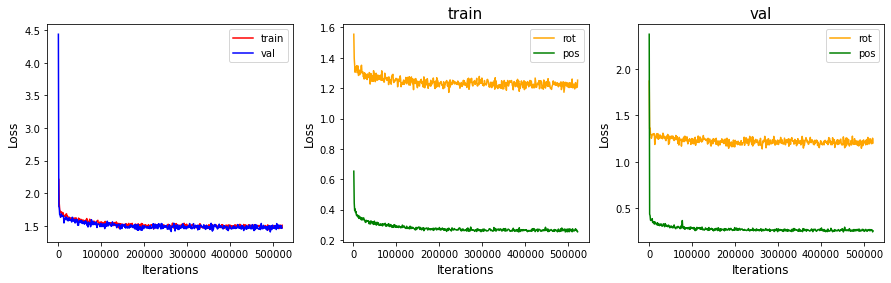

Ablation = small-17.6
Coverged at Iter 769000 (1.432400).
train: loss=1.4271; rot=1.2677; pos=0.1594
for overleaf: 1.427 & 1.268 & 0.159
val: loss=1.4324; rot=1.2716; pos=0.1608
for overleaf: 1.432 & 1.272 & 0.161


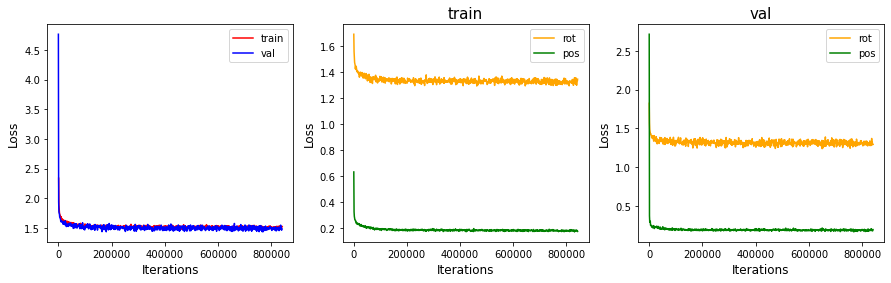

Ablation = large-17.6
Coverged at Iter 494000 (1.426400).
train: loss=2.2878; rot=2.1626; pos=0.1252
for overleaf: 2.288 & 2.163 & 0.125
val: loss=1.4264; rot=1.2498; pos=0.1766
for overleaf: 1.426 & 1.250 & 0.177


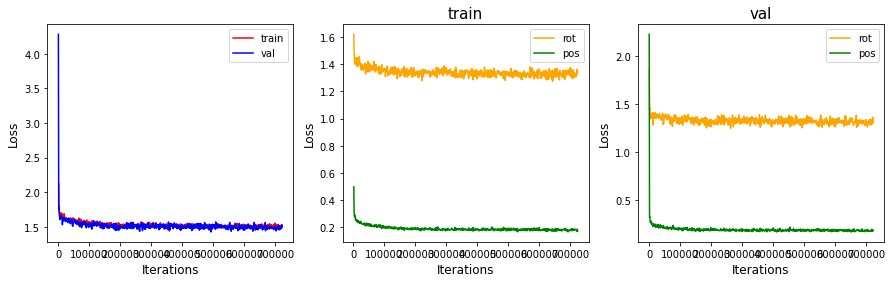

In [383]:
title = 'Ablation'
version_list = ['small-10.0', 'large-10.0', 'small-17.6', 'large-17.6']
              
model_list = [
    'codesign_multinomial_step100_posiscale10.0_6-128-64-4_structure-modal_2024_02_16__15_13_51',
    'codesign_multinomial_step100_posiscale10.0_6-512-256-2_structure-modal_2024_02_16__19_55_26',
    'codesign_multinomial_step100_posiscale17.6_6-128-64-4_structure-modal_2024_02_12__20_29_24',
    'codesign_multinomial_step100_posiscale17.6_6-512-256-2_structure-modal_2024_02_12__20_29_24',
]

loss_type_list_all = [
    ['rot', 'pos']
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'orange', 'green']
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

* Given Sequence

Ablation = small-10.0
Coverged at Iter 558000 (1.257000).
train: loss=1.1725; rot=0.9148; pos=0.2577
for overleaf: 1.173 & 0.915 & 0.258
val: loss=1.2570; rot=0.9920; pos=0.2650
for overleaf: 1.257 & 0.992 & 0.265


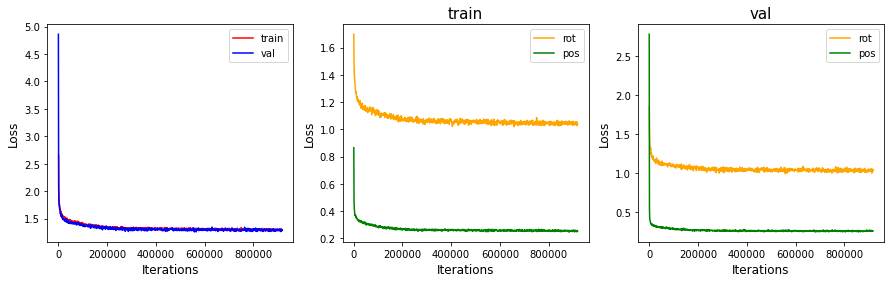

Ablation = large-10.0
Coverged at Iter 494000 (1.240900).
train: loss=1.5633; rot=1.4014; pos=0.1619
for overleaf: 1.563 & 1.401 & 0.162
val: loss=1.2409; rot=0.9863; pos=0.2546
for overleaf: 1.241 & 0.986 & 0.255


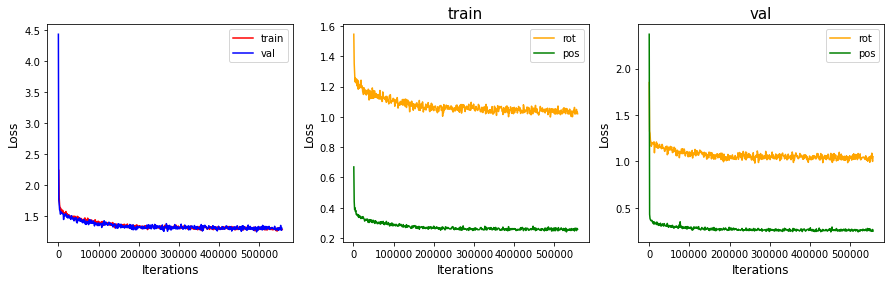

Ablation = small-17.6
Coverged at Iter 164000 (1.293900).
train: loss=1.4053; rot=1.2604; pos=0.1449
for overleaf: 1.405 & 1.260 & 0.145
val: loss=1.2939; rot=1.1075; pos=0.1863
for overleaf: 1.294 & 1.107 & 0.186


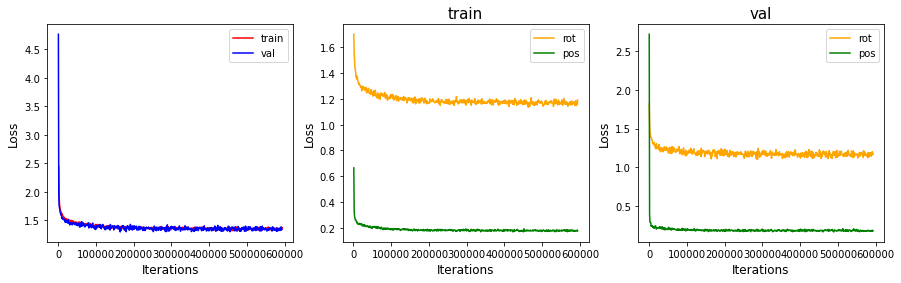

Ablation = large-17.6
Coverged at Iter 494000 (1.287900).
train: loss=1.7450; rot=1.6429; pos=0.1021
for overleaf: 1.745 & 1.643 & 0.102
val: loss=1.2879; rot=1.1110; pos=0.1769
for overleaf: 1.288 & 1.111 & 0.177


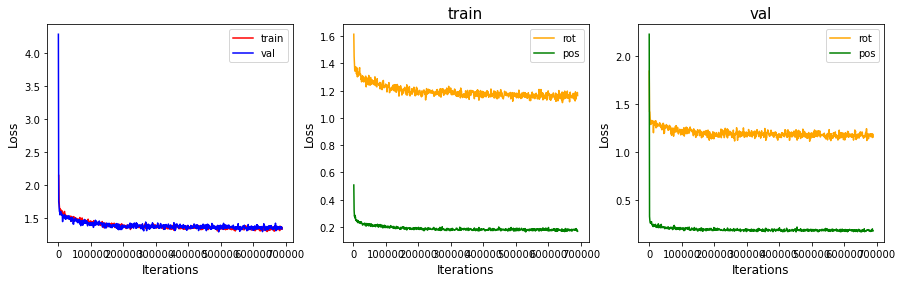

In [384]:
title = 'Ablation'
version_list = ['small-10.0', 'large-10.0', 'small-17.6', 'large-17.6']
              
model_list = [
    'codesign_origindiff_structureOnly_2024_01_20__16_37_11',
    'codesign_multinomial_step100_posiscale10.0_6-512-256_structureOnly_2024_02_16__15_13_51',
    'codesign_multinomial_step100_posiscale17.6_6-128-64-4_structureOnly_2024_02_16__19_55_26',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_structureOnly_2024_02_10__22_38_44',
]

loss_type_list_all = [
    ['rot', 'pos']
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'orange', 'green']
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

## Collect the Stoping Point

In [385]:
with open('../Model_Lists/model_stoping.txt', 'w') as wf:
    for model in sorted(iter_sele_dict.keys()):
        if not ('Fit' in model or 'Ene' in model):
            wf.write(model + '_' + str(iter_sele_dict[model]['iter']) + '\n')

# Guided Diffusion (Previous)

In [277]:
LOG_PATH = '../../Logs/logs_guidedDiff_pre/'

## Evoluation Guidence

fitness guidance = fitness-length
Coverged at Iter 176000 (1.712500).
train: loss=9.9035
val: loss=1.7125


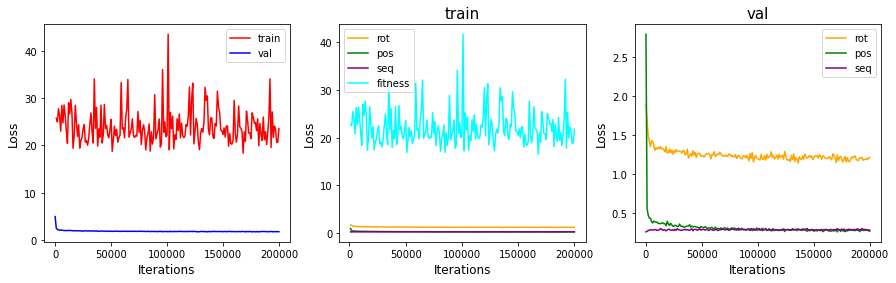

fitness guidance = fitness-0.01
Coverged at Iter 387000 (1.686400).
train: loss=5.3984
val: loss=1.6864


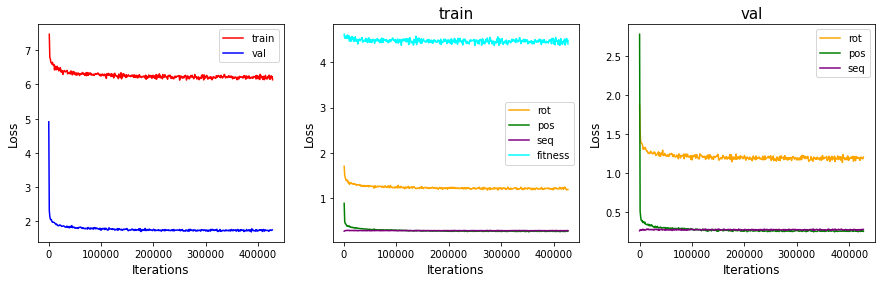

fitness guidance = fitness-0.05
Coverged at Iter 387000 (1.686200).
train: loss=5.4073
val: loss=1.6862


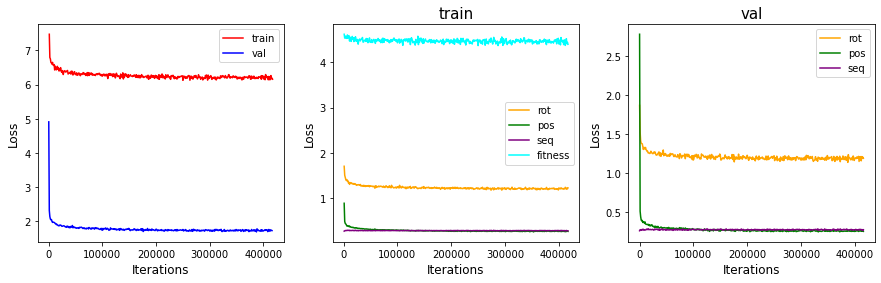

fitness guidance = fitness-0.1
Coverged at Iter 387000 (1.690500).
train: loss=5.3993
val: loss=1.6905


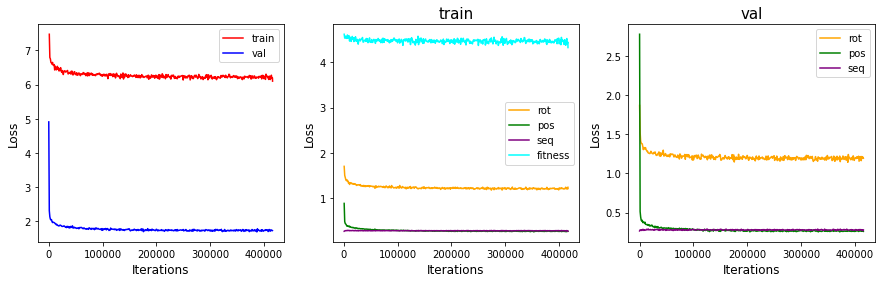

fitness guidance = fitness-0.5
Coverged at Iter 387000 (1.686600).
train: loss=5.3923
val: loss=1.6866


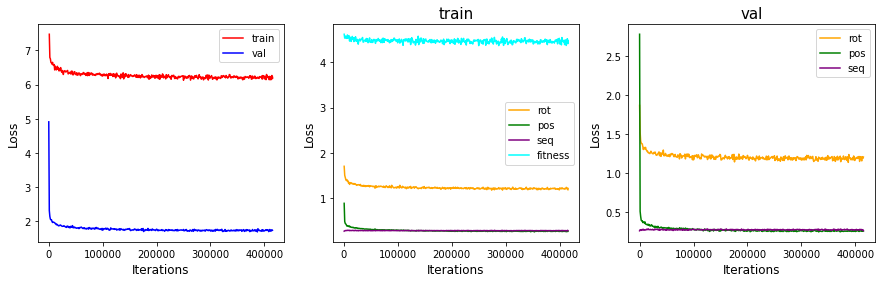

fitness guidance = fitness-1.0
Coverged at Iter 387000 (1.684300).
train: loss=5.3736
val: loss=1.6843


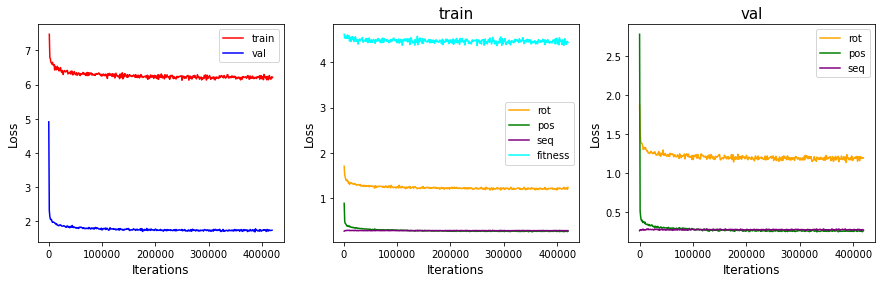

fitness guidance = fitness-5.0
Coverged at Iter 387000 (1.689000).
train: loss=5.3738
val: loss=1.6890


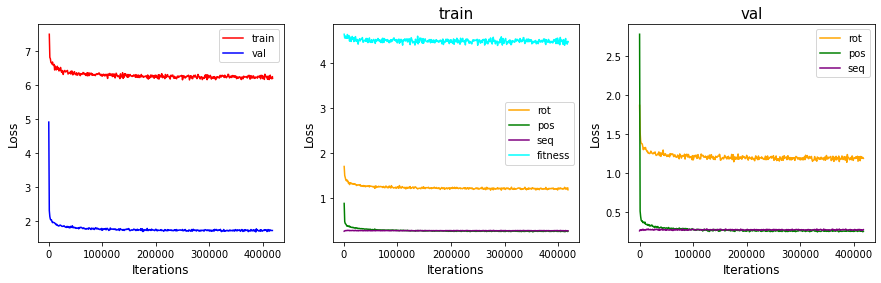

fitness guidance = fitness-10.0
Coverged at Iter 387000 (1.685400).
train: loss=5.3578
val: loss=1.6854


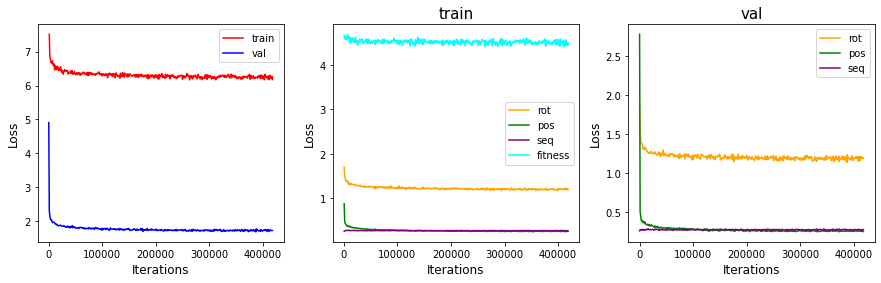

In [278]:
title = 'fitness guidance'
version_list = ['fitness-length', 'fitness-0.01', 'fitness-0.05', 
                'fitness-0.1', 'fitness-0.5', 'fitness-1.0', 'fitness-5.0', 'fitness-10.0']

model_list = [
    'codesign_SingleChain_2023_09_26__14_45_42_diffab_fitness-length',
    'codesign_SingleChain_fitness_2023_10_03__01_30_24_diffab_fitness-0.01',
    'codesign_SingleChain_fitness_2023_10_03__01_30_24_diffab_fitness-0.05',
    'codesign_SingleChain_fitness_2023_10_03__01_30_24_diffab_fitness-0.1',
    'codesign_SingleChain_fitness_2023_10_03__01_30_24_diffab_fitness-0.5',
    'codesign_SingleChain_fitness_2023_10_03__01_30_24_diffab_fitness-none',
    'codesign_SingleChain_fitness_2023_10_03__01_30_24_diffab_fitness-5',
    'codesign_SingleChain_fitness_2023_10_03__01_30_24_diffab_fitness-10',
]

loss_type_list_all = [
    ['rot', 'pos', 'seq', 'fitness'],
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'orange', 'green', 'purple', 'cyan'],
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

In [ ]:
title = 'steps (guided)'
version_list = ['1', '2', '3', '4', '5', '10', '50', '100']

model_list = [
    'codesign_diffab_complete_gen_share-true_step1_lr1.e-4_wd0.0_2023_12_15__01_34_00_diffab_less_step1_fitness-none',
    'codesign_diffab_complete_gen_share-true_step2_lr1.e-4_wd0.0_2023_12_15__01_34_04_diffab_less_step2_fitness-none',
    'codesign_diffab_complete_gen_share-true_step3_lr1.e-4_wd0.0_2023_12_15__01_34_03_diffab_less_step3_fitness-none',
    'codesign_diffab_complete_gen_share-true_step4_lr1.e-4_wd0.0_2023_12_15__01_34_01_diffab_less_step4_fitness-none',
    'codesign_diffab_complete_gen_share-true_step5_lr1.e-4_wd0.0_2023_12_15__01_34_01_diffab_less_step5_fitness-none',
    'codesign_diffab_complete_gen_share-true_step10_lr1.e-4_wd0.0_2023_12_15__01_34_00_diffab_less_step10_fitness-none',
    'codesign_diffab_complete_gen_share-true_step50_lr1.e-4_wd0.0_2023_12_15__01_34_01_diffab_less_step50_fitness-none',
    'codesign_SingleChain_fitness_2023_10_03__01_30_24_diffab_fitness-none'
]

loss_type_list_all = [
    ['rot', 'pos', 'seq', 'fitness'],
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'orange', 'green', 'purple', 'cyan'],
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

In [ ]:
title = 'scaling_weight (guided)'
version_list = ['2.2', '4.4', '8.8', '10', '17.6']

model_list = [
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale2.2_guide_2024_01_13__15_32_10_diffab_step100_posiscale2.2_fitness-none',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale4.4_guide_2024_01_13__15_08_37_diffab_step100_posiscale4.4_fitness-none',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale8.8_guide_2024_01_13__15_08_37_diffab_step100_posiscale8.8_fitness-none',
    'codesign_SingleChain_fitness_2023_10_03__01_30_24_diffab_fitness-none',
    'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale17.6_guide_2024_01_13__15_08_37_diffab_step100_posiscale17.6_fitness-none'
]

loss_type_list_all = [
    ['rot', 'pos', 'seq', 'fitness'],
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'orange', 'green', 'purple', 'cyan'],
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

## Energy Guidance

energy guidance = no_norm
Coverged at Iter 15000 (2.428100).
train: loss=3.1035
val: loss=2.4281


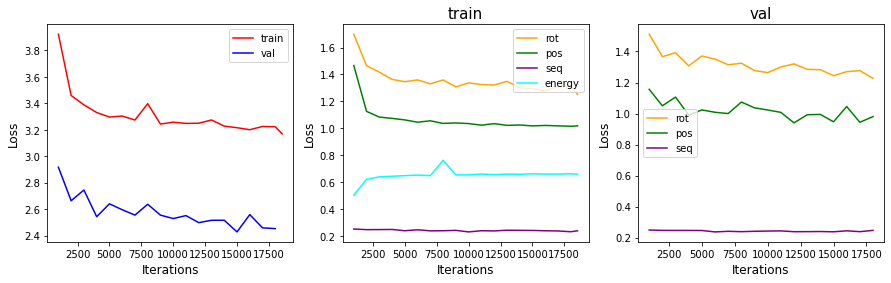

energy guidance = no_norm (fix_contact)
Coverged at Iter 1 (5.670800).
train: loss=55284149019213824.0000
val: loss=5.6708


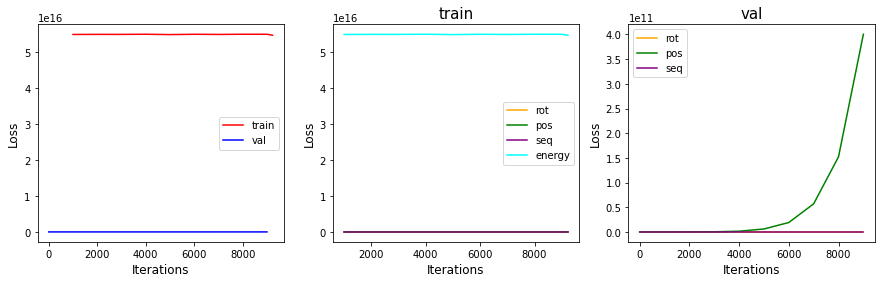

energy guidance = Boltzmann
Coverged at Iter 15000 (2.428100).
train: loss=3.1035
val: loss=2.4281


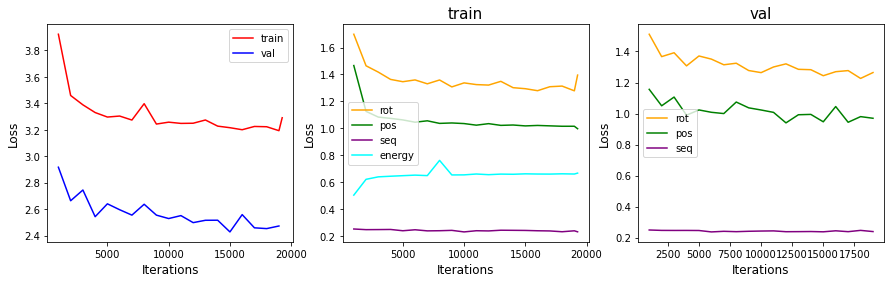

energy guidance = Boltzmann (fix_contact)
Coverged at Iter 1 (5.668300).
train: loss=9005330943967232.0000
val: loss=5.6683


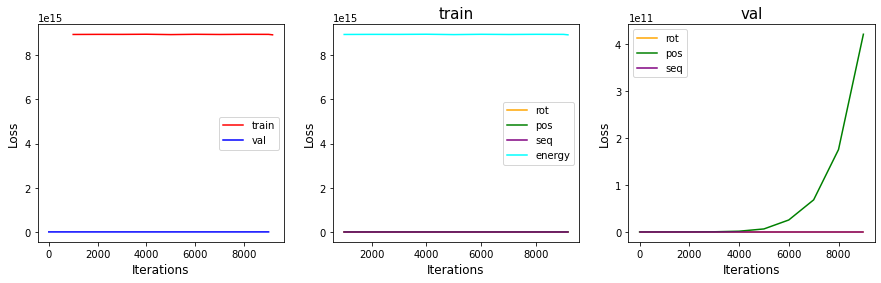

energy guidance = negative-Boltzmann
Coverged at Iter 1 (5.668300).
train: loss=9005330943967232.0000
val: loss=5.6683


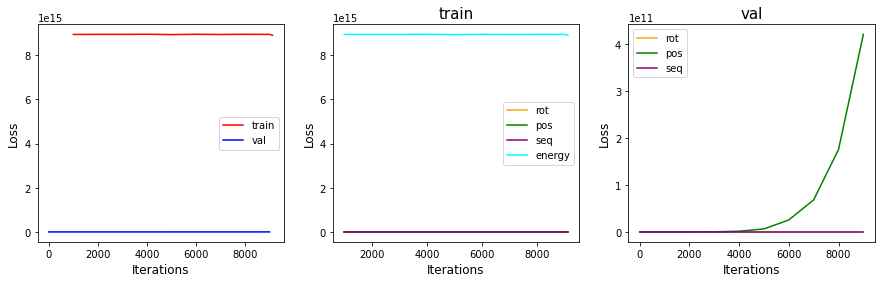

energy guidance = no-contact
Coverged at Iter 15000 (2.435700).
train: loss=3.1083
val: loss=2.4357


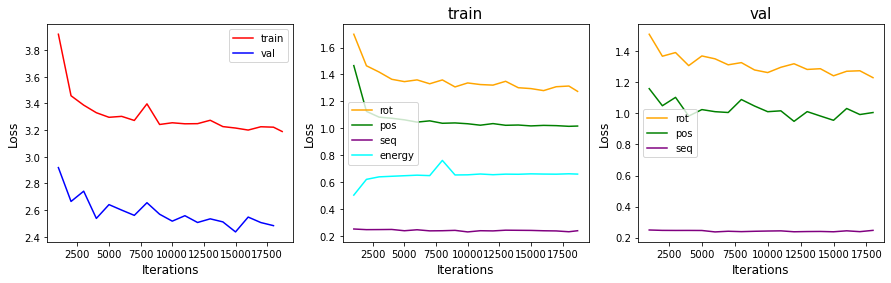

In [279]:
title = 'energy guidance'
version_list = ['no_norm', 'no_norm (fix_contact)', 
                'Boltzmann', 'Boltzmann (fix_contact)', 'negative-Boltzmann',
                'no-contact']

model_list = [
    'codesign_SingleChain_2023_09_22__23_01_32_diffab_energy-none',
    'codesign_SingleChain_energy_2023_10_03__01_38_32_diffab_energy-none',
    'codesign_SingleChain_2023_09_22__23_01_32_diffab_energy-Boltzmann_1',
    'codesign_SingleChain_energy_2023_10_03__01_38_03_diffab_energy-Boltzmann',
    'codesign_SingleChain_energy_2023_10_03__01_38_32_diffab_energy-negative-Boltzmann',
    'codesign_SingleChain_2023_09_21__21_39_35_diffab_energy-Boltzmann_noContact'
]

loss_type_list_all = [
    ['rot', 'pos', 'seq', 'energy'],
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'orange', 'green', 'purple', 'cyan'],
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )
    

## Combined Guidance

guidance = origin
Coverged at Iter 458000 (1.608100).
train: loss=1.5579
val: loss=1.6081


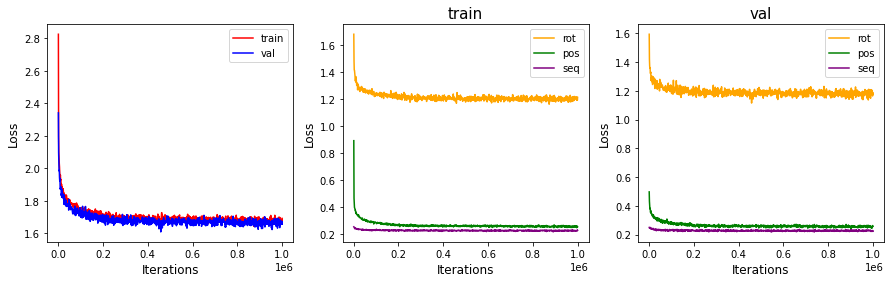

guidance = fitness-only
Coverged at Iter 387000 (1.684300).
train: loss=5.3736
val: loss=1.6843


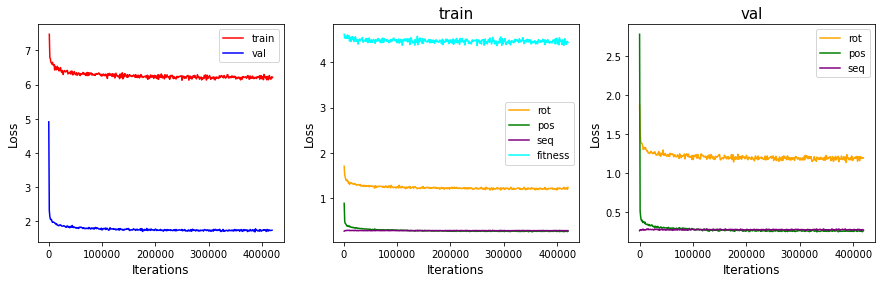

guidance = energy-only
Coverged at Iter 15000 (2.428100).
train: loss=3.1035
val: loss=2.4281


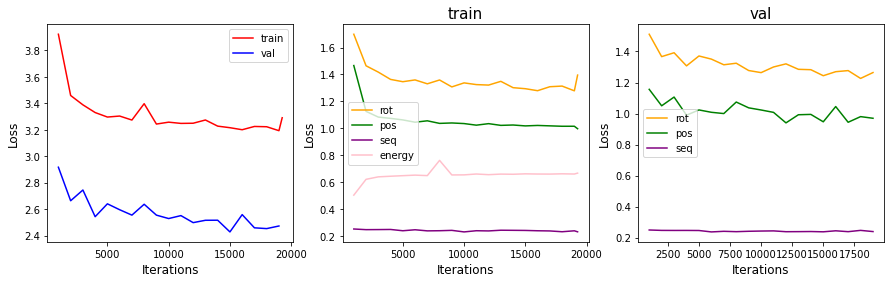

guidance = combined
Coverged at Iter 1 (5.614500).
train: loss=8833369580240896.0000
val: loss=5.6145


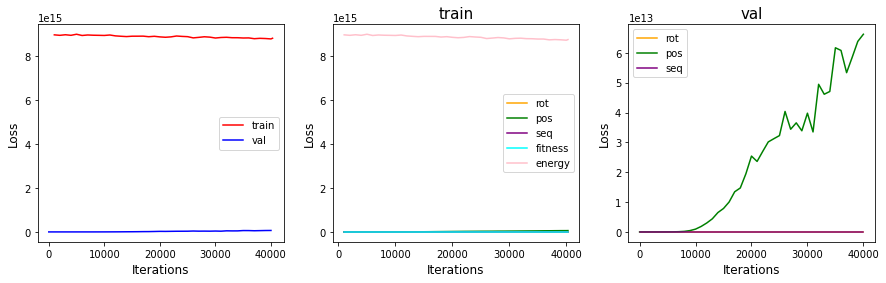

In [280]:
title = 'guidance'

iter_sele_dict = model_stat(
        model_list = ['codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48'], 
        version_list = ['origin'], 
        title = title, 
        log_path = '../../Logs/logs_originDiff/', 
        loss_type_list = ['rot', 'pos', 'seq', 'fitness', 'energy'], 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = ['red', 'blue', 'orange', 'green', 'purple', 'cyan', 'pink']
    )


version_list = ['fitness-only', 'energy-only', 'combined']

model_list = [
    'codesign_SingleChain_fitness_2023_10_03__01_30_24_diffab_fitness-none',
    'codesign_SingleChain_2023_09_22__23_01_32_diffab_energy-Boltzmann_1',
    'codesign_SingleChain_fitness_2023_10_03__23_22_59_diffab_energy-Boltzmann_fitness-none'
]

loss_type_list_all = [
    ['rot', 'pos', 'seq', 'fitness', 'energy'],
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'orange', 'green', 'purple', 'cyan', 'pink'],
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

# Guided Diffusion (new)

In [296]:
LOG_PATH = '../../Logs/logs_guidedDiff/'

## Evolution Guidance

fitness guidance = mse-none
Coverged at Iter 174000 (1.731600).
train: loss=2.0052
val: loss=1.7316


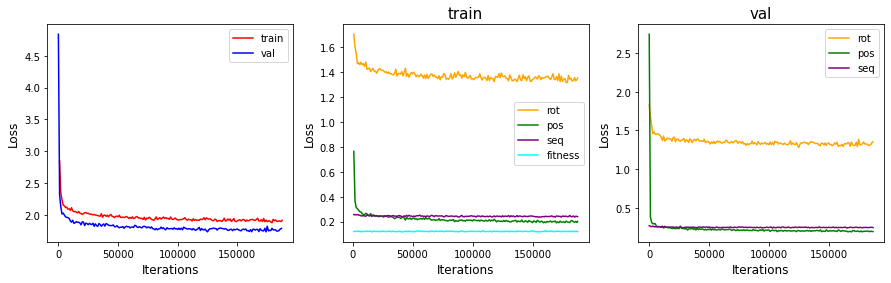

fitness guidance = mse-negative
Coverged at Iter 174000 (1.732400).
train: loss=20.5803
val: loss=1.7324


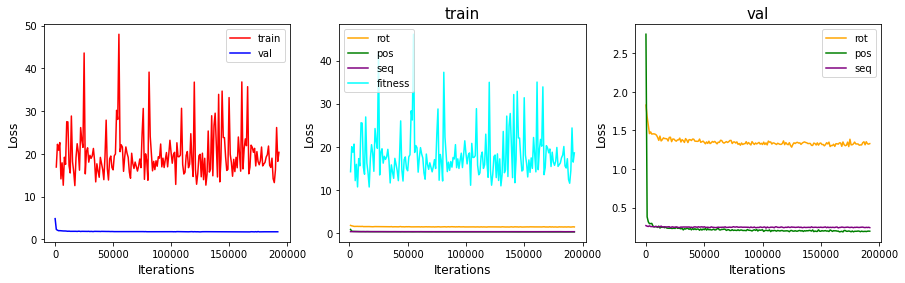

fitness guidance = mse-length
Coverged at Iter 174000 (1.733300).
train: loss=1.9977
val: loss=1.7333


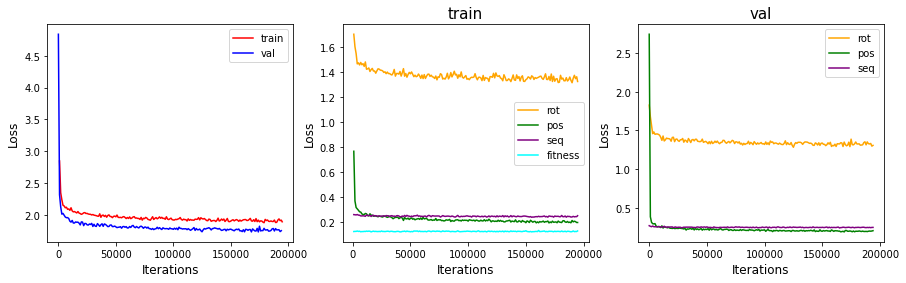

In [297]:
title = 'fitness guidance'
version_list = ['mse-none', 'mse-negative', 'mse-length']

model_list = [
    'codesign_multinomial_step100_posiscale17.6_6-128-64_guided_2024_02_05__11_46_27_guidedDiffsmall_Fit-mse-none',
    'codesign_multinomial_step100_posiscale17.6_6-128-64_guided_2024_02_05__11_47_11_guidedDiffsmall_Fit-mse-length',
    'codesign_multinomial_step100_posiscale17.6_6-128-64_guided_2024_02_05__11_47_12_guidedDiffsmall_Fit-mse-negative',
]

loss_type_list_all = [
    ['rot', 'pos', 'seq', 'fitness'],
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'orange', 'green', 'purple', 'cyan'],
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

fitness guidance = mse
Coverged at Iter 174000 (1.731600).
train: loss=2.0052
val: loss=1.7316


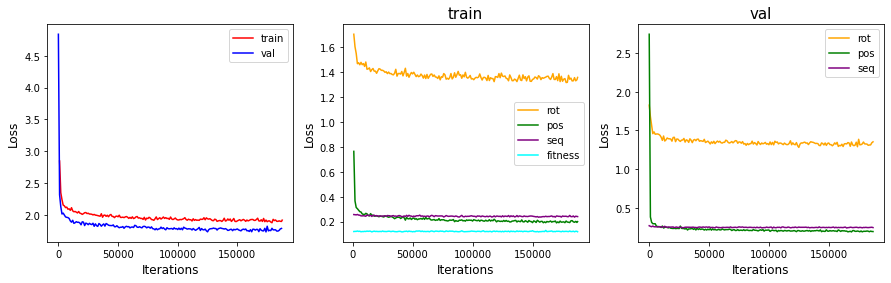

fitness guidance = cosine
Coverged at Iter 174000 (1.754500).
train: loss=1.8748
val: loss=1.7545


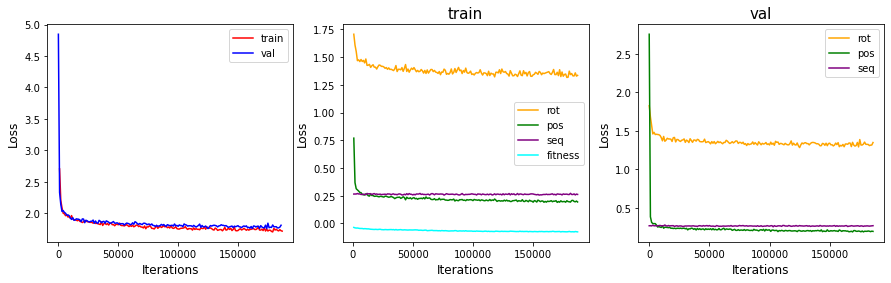

fitness guidance = direction
Coverged at Iter 332000 (1.625200).
train: loss=0.7234
val: loss=1.6252


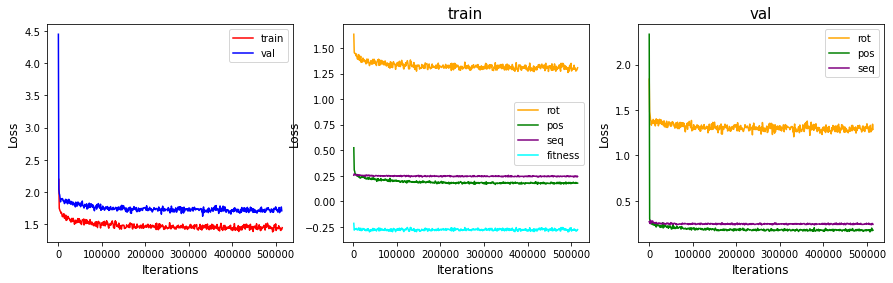

fitness guidance = gt_fitness
Coverged at Iter 332000 (1.612300).
train: loss=1.2535
val: loss=1.6123


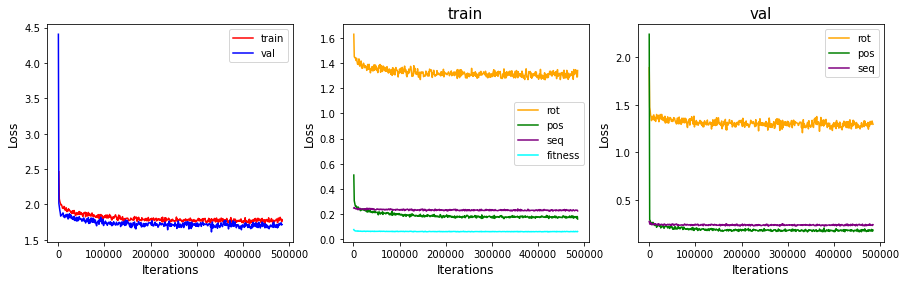

fitness guidance = cosine-20
Coverged at Iter 278000 (1.697800).
train: loss=2.6889
val: loss=1.6978


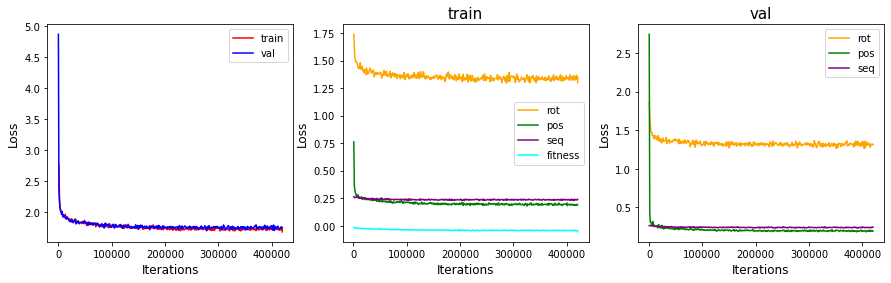

In [298]:
title = 'fitness guidance'
version_list = ['mse', 'cosine', 'direction', 'gt_fitness', 'cosine-20']

model_list = [
    'codesign_multinomial_step100_posiscale17.6_6-128-64_guided_2024_02_05__11_46_27_guidedDiffsmall_Fit-mse-none',
    'codesign_multinomial_step100_posiscale17.6_6-128-64_guided_2024_02_05__11_46_27_guidedDiffsmall_Fit-cosine-none',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided_2024_02_05__02_51_16_guidedDiff_Fit-direction-none',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided_2024_02_05__02_51_16_guidedDiff_Fit-gt_fitness-none',
    'codesign_multinomial_step100_posiscale17.6_6-128-64_guided_2024_02_06__05_43_42_guidedDiffsmall_Fit-cosine-none_tmax20',
]

loss_type_list_all = [
    ['rot', 'pos', 'seq', 'fitness'],
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'orange', 'green', 'purple', 'cyan'],
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

## Energy Guidance

energy guidance = mse
Coverged at Iter 1 (5.200000).
train: loss=18433744896.0000
val: loss=5.2000


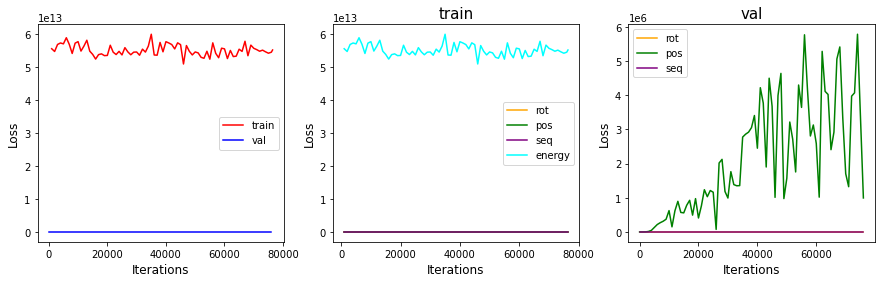

energy guidance = cosine
Unconverged


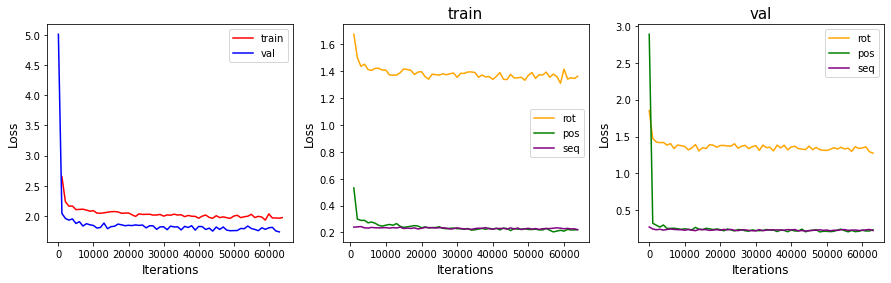

energy guidance = all-energy
Coverged at Iter 36000 (1.750700).
train: loss=1.3491
val: loss=1.7507


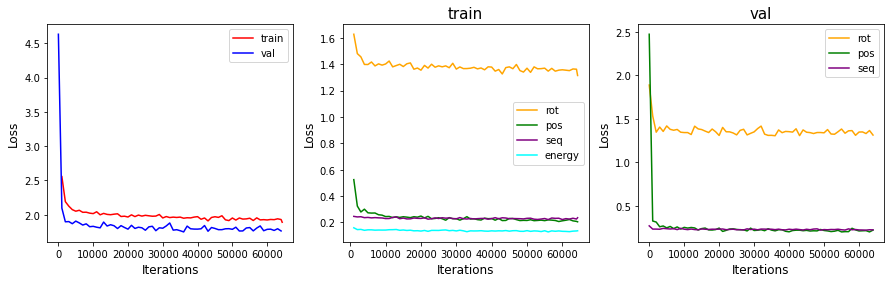

energy guidance = with-resi
Coverged at Iter 65000 (1.732600).
train: loss=2.1976
val: loss=1.7326


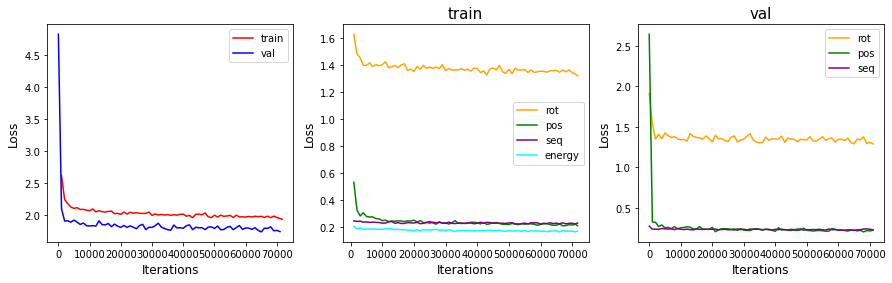

energy guidance = tmax20
Coverged at Iter 35000 (1.793700).
train: loss=1.4923
val: loss=1.7937


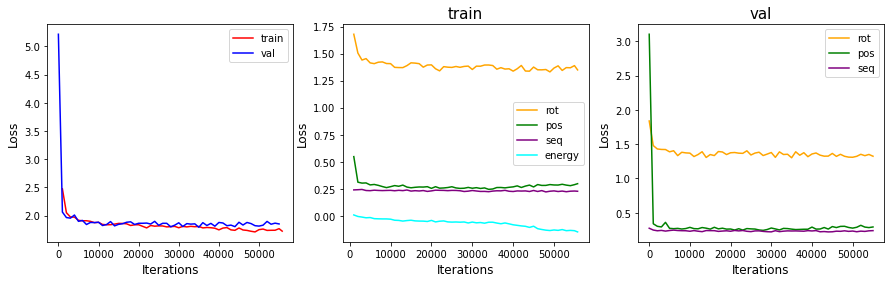

In [299]:
title = 'energy guidance'
version_list = ['mse', 'cosine', 'all-energy', 'with-resi', 'tmax20']

model_list = [
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided_2024_02_05__12_39_50_guidedDiffunnormed_Ene-mse-Boltzmann-Repul',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided_2024_02_05__12_39_50_guidedDiffunnormed_Ene-cosine-Boltzmann-Repul',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided_2024_02_05__12_39_50_guidedDiffunnormed_Ene-cosine-Boltzmann-all',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided_2024_02_05__12_39_50_guidedDiffunnormed_Ene-cosine-Boltzmann-Repul-withResi',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided_2024_02_05__18_38_30_guidedDiffunnormed_Ene-cosine-Boltzmann-Repul_tmax20',
]

loss_type_list_all = [
    ['rot', 'pos', 'seq', 'energy'],
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'orange', 'green', 'purple', 'cyan'],
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

energy guidance = cosine
Unconverged


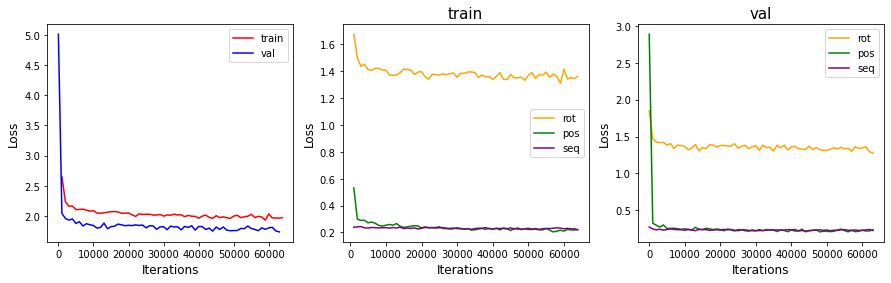

energy guidance = without_unorm
Coverged at Iter 63000 (1.716000).
train: loss=2.1188
val: loss=1.7160


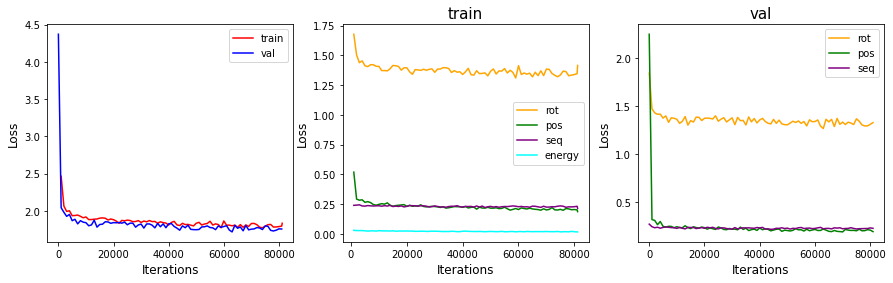

energy guidance = cosine-negative
Coverged at Iter 63000 (1.716900).
train: loss=1.1937
val: loss=1.7169


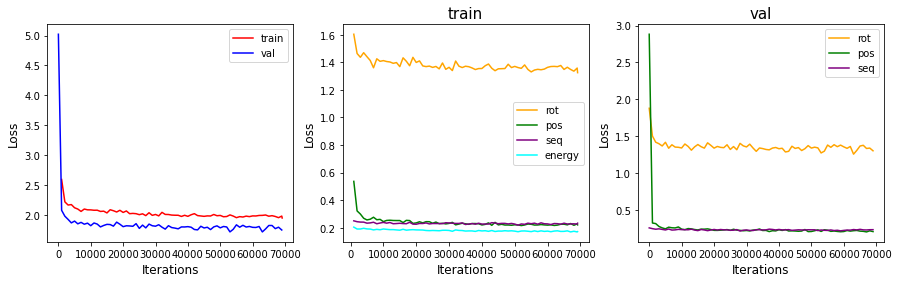

In [300]:
title = 'energy guidance'
version_list = ['cosine', 'without_unorm', 'cosine-negative']

model_list = [
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided_2024_02_05__12_39_50_guidedDiffunnormed_Ene-cosine-Boltzmann-Repul',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided_2024_02_05__02_47_47_guidedDiff_Ene-cosine-Boltzmann-Repul',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided_2024_02_05__12_39_50_guidedDiffunnormed_Ene-cosine-negative-Boltzmann-Repul',
]

loss_type_list_all = [
    ['rot', 'pos', 'seq', 'energy'],
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'orange', 'green', 'purple', 'cyan'],
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

## Combined

energy guidance = ene-cosine
Coverged at Iter 119000 (1.808600).
train: loss=2.7584
val: loss=1.8086


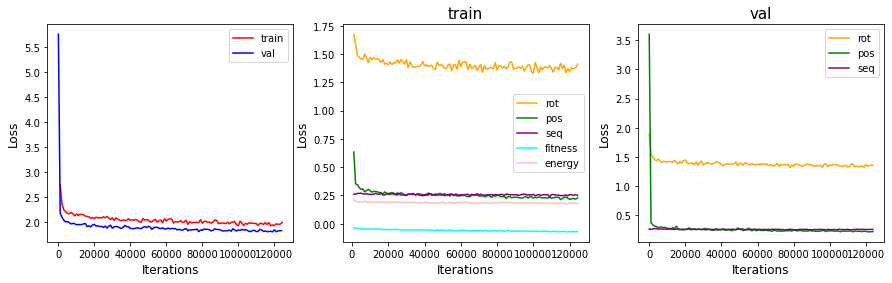

energy guidance = ene-direction
Coverged at Iter 163000 (1.777900).
train: loss=0.8167
val: loss=1.7779


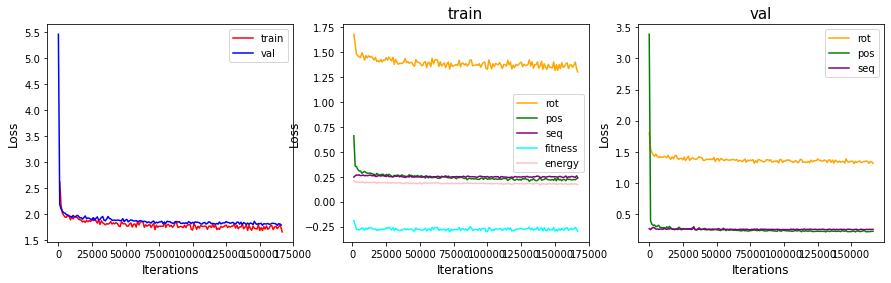

energy guidance = ene-gt
Coverged at Iter 163000 (1.760100).
train: loss=1.4451
val: loss=1.7601


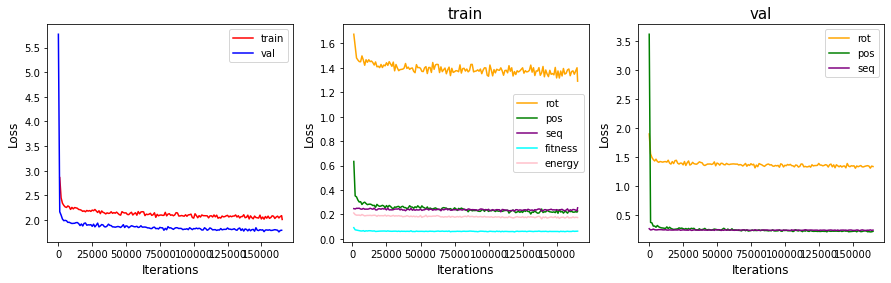

energy guidance = ene-cosine-tmax
Coverged at Iter 78000 (1.798400).
train: loss=2.7644
val: loss=1.7984


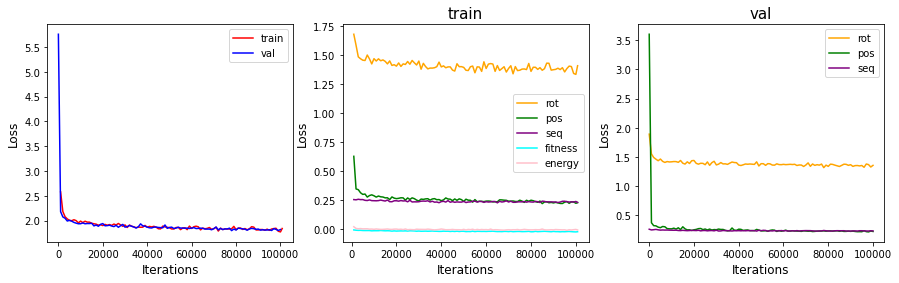

In [301]:
title = 'energy guidance'
version_list = ['ene-cosine', 'ene-direction', 'ene-gt', 'ene-cosine-tmax']

model_list = [
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided-smallbatch_2024_02_05__13_53_42_guidedDiffunnormed_Ene-cosine-Boltzmann-Repul_Fit-cosine-none',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided-smallbatch_2024_02_05__13_53_42_guidedDiffunnormed_Ene-cosine-Boltzmann-Repul_Fit-direction-none',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided-smallbatch_2024_02_05__13_53_42_guidedDiffunnormed_Ene-cosine-Boltzmann-Repul_Fit-gt_fitness-none',
    'codesign_multinomial_step100_posiscale17.6_6-512-256_guided-smallbatch_2024_02_05__22_30_24_guidedDiffunnormed_Ene-cosine-Boltzmann-Repul_Fit-cosine-none_tmax20',
]

loss_type_list_all = [
    ['rot', 'pos', 'seq', 'fitness', 'energy'],
] * len(model_list)

color_list_all = [
    ['red', 'blue', 'orange', 'green', 'purple', 'cyan', 'pink'],
] * len(model_list)

for model, version, loss_types, color_list in zip(model_list, version_list, loss_type_list_all, color_list_all):
    iter_sele_dict = model_stat(
        model_list = [model], 
        version_list = [version], 
        title = title, 
        log_path = LOG_PATH, 
        loss_type_list = loss_types, 
        iter_sele_dict = iter_sele_dict, 
        interval = interval,
        color_list = color_list
    )

## Collect the Stoping Point

In [302]:
with open('../Model_Lists/model_stoping_guided.txt', 'w') as wf:
    for model in sorted(iter_sele_dict.keys()):
        if 'Fit' in model or 'Ene' in model:
            wf.write(model + '_' + str(iter_sele_dict[model]['iter']) + '\n')

# Autoencoder

In [312]:
d = dict_load('../../Results/originDiff/sample_sele_forAF2/codesign_multinomial_step100_posiscale17.6_6-512-256_2024_02_01__00_55_13/foldability_SR_dict.pkl')

In [314]:
d

{'len149_0_4': [0.0268,
  0.0403,
  0.0201,
  0.0336,
  0.0268,
  0.047,
  0.0268,
  0.0268,
  0.0268,
  0.0336],
 'len100_0_3': [0.05, 0.03, 0.03, 0.02, 0.04, 0.05, 0.03, 0.03, 0.05, 0.04],
 'len83_0_4': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'len41_0_6': [0.0488,
  0.0488,
  0.0488,
  0.0488,
  0.0488,
  0.0488,
  0.0488,
  0.0488,
  0.0488,
  0.0488],
 'len52_0_4': [0.0192,
  0.0192,
  0.0192,
  0.0192,
  0.0385,
  0.0192,
  0.0192,
  0.0192,
  0.0192,
  0.0192],
 'len142_0_8': [0.0704,
  0.0634,
  0.0775,
  0.0634,
  0.0423,
  0.0704,
  0.0563,
  0.0634,
  0.0845,
  0.0775],
 'len133_0_2': [0.0752,
  0.0827,
  0.0827,
  0.0752,
  0.0752,
  0.0752,
  0.0752,
  0.0752,
  0.0902,
  0.0752],
 'len110_0_1': [0.0455,
  0.0455,
  0.0545,
  0.0455,
  0.0455,
  0.0455,
  0.0545,
  0.0364,
  0.0455,
  0.0455],
 'len94_0_2': [0.117,
  0.1277,
  0.1064,
  0.117,
  0.1383,
  0.1064,
  0.1277,
  0.117,
  0.117,
  0.117],
 'len194_0_9': [0.0361,
  0.0206,
  0.0155,
  0.0361,
  0.030

# Latent Diffusion

In [227]:
d = dict_load('../../Results/originDiff/Features/codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale2.2_2024_01_13__14_05_12/len99_0_9.pkl')

In [228]:
d.keys()

dict_keys(['phi', 'psi', 'omega', 'seq', 'clash'])

In [242]:
d['phi'][10]

-2.9118368825921306

In [230]:
d['omega'][4]

3.139393595303678

In [231]:
d['clash']

9

In [238]:
d2 = dict_load('../Evaluation/temp.pkl')

In [239]:
d2['omega'][4]

3.139393595303678

In [241]:
d2['phi'][10]

-2.911836882592131

In [250]:
d = dict_load('../../Results/originDiff/Features/codesign_RememberPadding_2024_01_29__20_57_00/len45_0_9.pkl')

In [252]:
d.keys()

dict_keys(['phi', 'psi', 'omega', 'seq', 'clash'])

In [307]:
a = np.random.rand(4,3)

In [308]:
a

array([[0.38065055, 0.66347011, 0.52037645],
       [0.1061755 , 0.39209001, 0.84279614],
       [0.77598184, 0.05952041, 0.77710306],
       [0.36298694, 0.1450497 , 0.99681251]])

In [309]:
np.std(a)

0.2977902844966277

In [310]:
np.std(a, axis = 0)

array([0.23941241, 0.23533339, 0.17196715])

In [311]:
np.mean(np.std(a, axis = 0))

0.21557098037906117

In [371]:
torch.zeors(3,4)

NameError: name 'torch' is not defined